In [1]:
# define the path of the data and project
data_path = 'D:/VScode/MRes/scienceweb.whoi.edu/itp/data/'

In [2]:
# read the cleaned xarray from local file
import xarray as xr
ds_cleaned_750=xr.open_dataset(f"{data_path}/ds_cleaned_750.nc")
# convert the profile data to string
ds_cleaned_750['profiler']=ds_cleaned_750['profiler'].astype(str)

In [3]:
ds_cleaned_750

<xarray.Dataset>
Dimensions:           (nprof: 44692, pressure: 148)
Coordinates:
    profiler          (nprof) <U13 'itp100grd0001' ... 'itp9grd1097'
    date              (nprof) datetime64[ns] ...
    lon               (nprof) float64 ...
    lat               (nprof) float64 ...
  * pressure          (pressure) float64 -10.0 -15.0 -20.0 ... -740.0 -745.0
Dimensions without coordinates: nprof
Data variables:
    temperature       (nprof, pressure) float64 ...
    salinity          (nprof, pressure) float64 ...
    dissolved_oxygen  (nprof, pressure) float64 ...

In [50]:
# read the cleaned xarray from local file
import xarray as xr
ds_cleaned_250=xr.open_dataset(f"{data_path}/ds_cleaned_250.nc")
# convert the profile data to string
ds_cleaned_250['profiler']=ds_cleaned_250['profiler'].astype(str)

In [51]:
ds_cleaned_250

<xarray.Dataset>
Dimensions:           (nprof: 67040, pressure: 48)
Coordinates:
    profiler          (nprof) <U13 'itp100grd0001' ... 'itp9grd1099'
    date              (nprof) datetime64[ns] ...
    lon               (nprof) float64 ...
    lat               (nprof) float64 ...
  * pressure          (pressure) float64 -10.0 -15.0 -20.0 ... -240.0 -245.0
Dimensions without coordinates: nprof
Data variables:
    temperature       (nprof, pressure) float64 ...
    salinity          (nprof, pressure) float64 ...
    dissolved_oxygen  (nprof, pressure) float64 ...

In [27]:
# function to plot the pc
import matplotlib.pyplot as plt

def plot_pc(pca_temp_df, pca_san_df, ds_cleaned, v_exp_temp, v_exp_san):
    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5), dpi=300)

    # Loop through all the PCs and plot them for temperature and salinity
    for i in range(pca_temp_df.shape[1]):
        # Plot the i-th PC for temperature in the left subplot
        axes[0].plot(pca_temp_df[f'pc {i+1}'], ds_cleaned['pressure'], label=f'PC {i+1}, v:{v_exp_temp[i]:.2f}')
        axes[0].set_title('Temperature')
        axes[0].set_xlabel('PC Values')
        axes[0].set_ylabel('Pressure (dbar)')
        # axes[0].invert_yaxis()
        axes[0].legend()

        # Plot the i-th PC for salinity in the right subplot
        axes[1].plot(pca_san_df[f'pc {i+1}'], ds_cleaned['pressure'], label=f'PC {i+1}, v:{v_exp_san[i]:.2f}')
        axes[1].set_title('Salinity')
        axes[1].set_xlabel('PC Values')
        axes[1].set_ylabel('Pressure (dbar)')
        # axes[1].invert_yaxis()
        axes[1].legend()

    # Adjust the spacing between the subplots
    fig.subplots_adjust(wspace=0.3)

    # Show the figure
    plt.show()


In [28]:
# function to plot the score:
import matplotlib.pyplot as plt
import numpy as np

def plot_score(temp_score, san_score):
    n_cols = temp_score.shape[1]  # number of principal components
    fig, axs = plt.subplots(nrows=2, ncols=n_cols, figsize=(15, 8), dpi=300)

    for i in range(n_cols):
        axs[0, i].hist(temp_score[:, i], bins=100, density=True)
        axs[0, i].set_xlim(np.quantile(temp_score, 0.001), np.quantile(temp_score, 0.999))
        axs[0, i].set_title(f'PC{i+1}')
        axs[0, i].set_xlabel('Temperature score')
        axs[0, i].set_ylabel('Probability density')
        #axs[0, i].set_yticklabels([str(int(ytick/len(temp_score))) for ytick in axs[0, i].get_yticks()])  # set ytick labels divided by 2

        axs[1, i].hist(san_score[:, i], bins=100, density=True)
        axs[1, i].set_xlim(np.quantile(san_score, 0.001), np.quantile(san_score, 0.999))
        axs[1, i].set_title(f'PC{i+1}')
        axs[1, i].set_xlabel('Salinity score')
        axs[1, i].set_ylabel('Probability density')
        # axs[1, i].set_yticklabels([str(int(ytick/len(temp_score))) for ytick in axs[1, i].get_yticks()])  # set ytick labels divided by 2

    plt.tight_layout()
    plt.show()


In [31]:
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def pca_score(ds_cleaned):
    # Normalize the data
    scaler = StandardScaler()
    temp_scaled = scaler.fit_transform(ds_cleaned['temperature'].values)
    san_scaled = scaler.fit_transform(ds_cleaned['salinity'].values)

    n_pc = 2  # number of principal components
    pca_T = PCA(n_components=n_pc)
    pca_S = PCA(n_components=n_pc)
    columns = [f'pc {i}' for i in range(1, n_pc+1)]

    pca_temp = pca_T.fit_transform(temp_scaled.T)
    pca_temp_df = pd.DataFrame(data=pca_temp, columns=columns)

    # pca for salinity
    pca_san = pca_S.fit_transform(san_scaled.T)
    pca_san_df = pd.DataFrame(data=pca_san, columns=columns)

    temp_score = temp_scaled.dot(zscore(pca_temp))
    san_score = san_scaled.dot(zscore(pca_san))

    v_exp_temp = pca_T.explained_variance_ratio_
    v_exp_san = pca_S.explained_variance_ratio_

    print(f'variation explained by PC1 and PC2 for temperature: {v_exp_temp}')
    print(f'variation explained by PC1 and PC2 for salinity: {v_exp_san}')

    plot_pc(pca_temp_df, pca_san_df, ds_cleaned, v_exp_temp, v_exp_san)
    plot_score(temp_score, san_score)

    temp_san_score=np.concatenate((temp_score,san_score),axis=1)
    
    return temp_san_score


In [39]:
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

def aic_bic_curve(temp_san_score, max_components=20):
    aic = []
    for i in range(2, max_components):
        gmm_model = GaussianMixture(n_components=i, covariance_type='full')
        gmm_model.fit(temp_san_score)
        aic.append(gmm_model.aic(temp_san_score))

    bic = []
    for i in range(2, max_components):
        gmm_model = GaussianMixture(n_components=i, covariance_type='full')
        gmm_model.fit(temp_san_score)
        bic.append(gmm_model.bic(temp_san_score))

    # calculate the gradient of bic
    bic_grad = np.gradient(bic)
    aic_grad = np.gradient(aic)

    # plot bic and bic_grad vs n_components side by side
    plt.figure(figsize=(18, 12), dpi=300)

    plt.subplot(2, 2, 1)
    plt.plot(range(2, max_components), aic)
    # set xticks to be integers
    plt.xticks(range(2, max_components))
    plt.xlabel('Number of components')
    plt.ylabel('AIC score')
    plt.grid()

    plt.subplot(2, 2, 2)
    plt.plot(range(2, max_components), aic_grad)
    # set xticks to be integers
    plt.xticks(range(2, max_components))
    plt.xlabel('Number of components')
    plt.ylabel('Gradient of AIC score')
    plt.grid()

    plt.subplot(2, 2, 3)
    plt.plot(range(2, max_components), bic)
    # set xticks to be integers
    plt.xticks(range(2, max_components))
    plt.xlabel('Number of components')
    plt.ylabel('BIC score')
    plt.grid()

    plt.subplot(2, 2, 4)
    plt.plot(range(2, max_components), bic_grad)
    # set xticks to be integers
    plt.xticks(range(2, max_components))
    plt.xlabel('Number of components')
    plt.ylabel('Gradient of BIC score')
    # add grid
    plt.grid()

    plt.tight_layout()
    plt.show()


In [44]:
'''
Claculate the silhouette score for GMM, when GMM is created using number of classes from 2 to max_components=20
'''
from sklearn.metrics import silhouette_score
import numpy as np

def silhouette_score_curve(temp_san_score, max_components=20):
    silhouette_scores = []
    for i in range(2, max_components):
        gmm_model = GaussianMixture(n_components=i, covariance_type='full')
        gmm_model.fit(temp_san_score)
        labels = gmm_model.predict(temp_san_score)
        silhouette_scores.append(silhouette_score(temp_san_score, labels))

    # calculate the gradient of silhouette_scores
    silhouette_scores_grad = np.gradient(silhouette_scores)

    # plot silhouette_scores and silhouette_scores_grad vs n_components side by side
    plt.figure(figsize=(18, 6), dpi=300)

    plt.subplot(1, 2, 1)
    plt.plot(range(2, max_components), silhouette_scores)
    # set xticks to be integers
    plt.xticks(range(2, max_components))
    plt.xlabel('Number of components')
    plt.ylabel('Silhouette score')
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(range(2, max_components), silhouette_scores_grad)
    # set xticks to be integers
    plt.xticks(range(2, max_components))
    plt.xlabel('Number of components')
    plt.ylabel('Gradient of Silhouette score')
    plt.grid()


    plt.show()

variation explained by PC1 and PC2 for temperature: [0.68892226 0.15651934]
variation explained by PC1 and PC2 for salinity: [0.44541149 0.23758103]


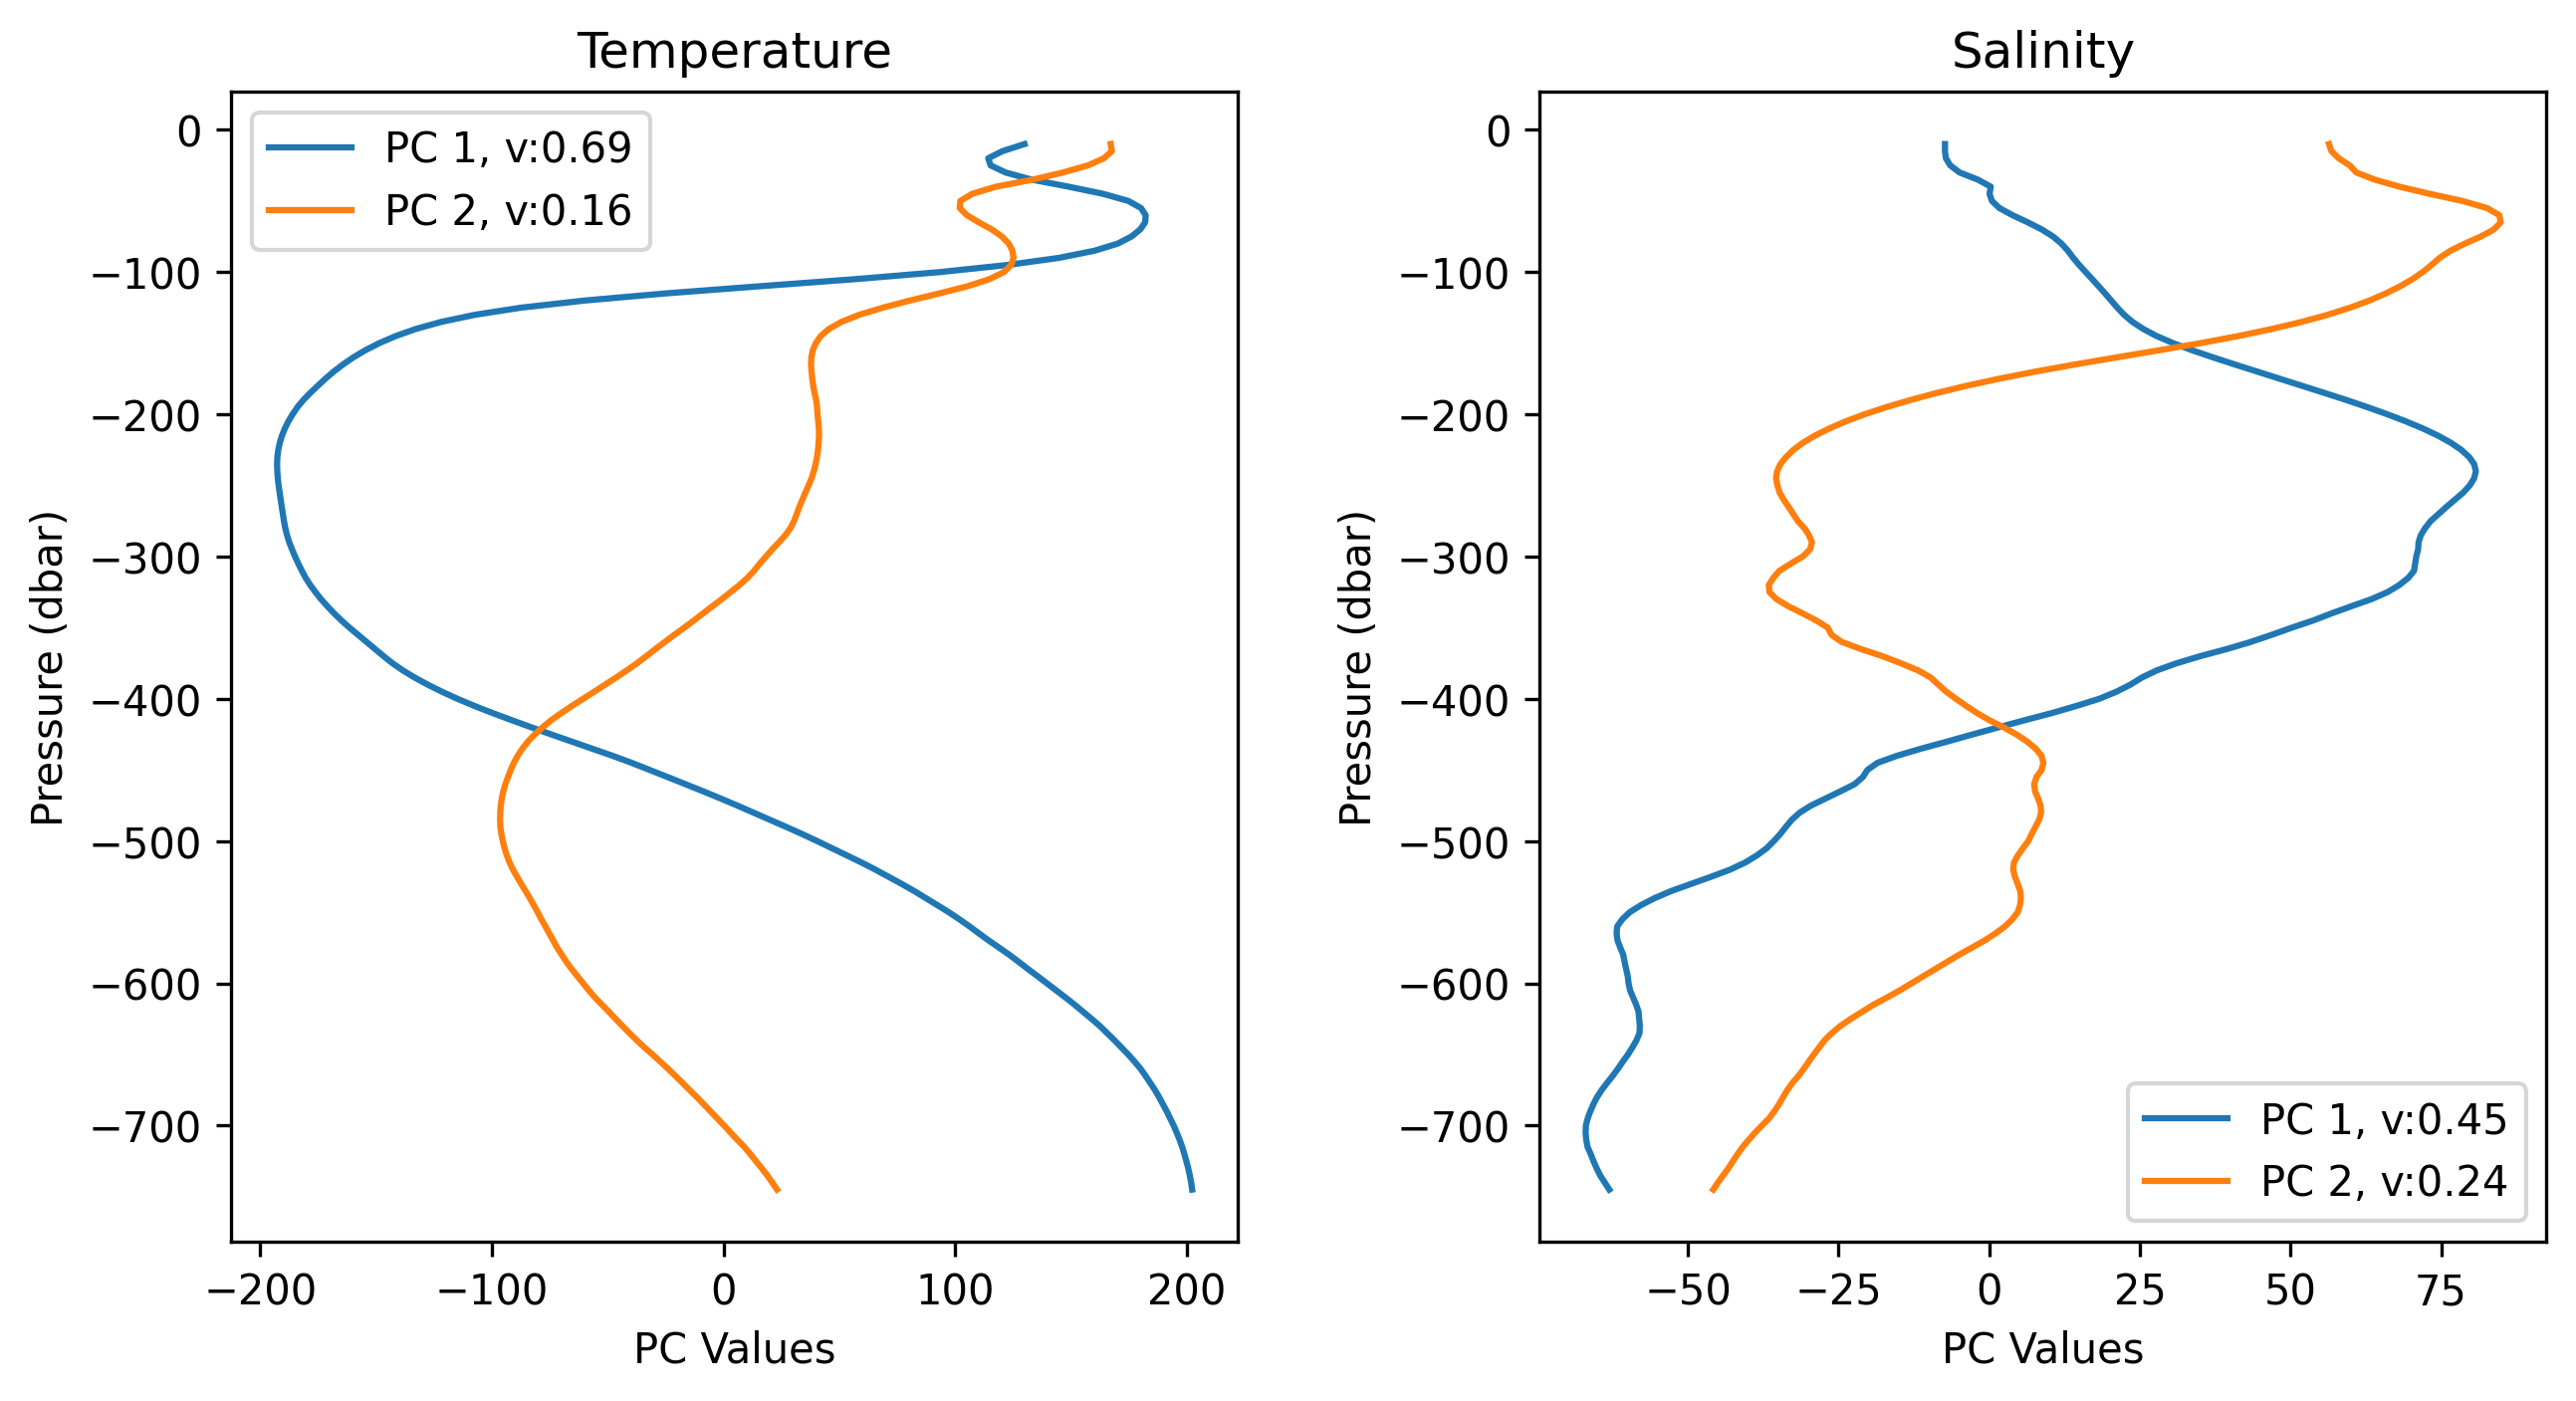

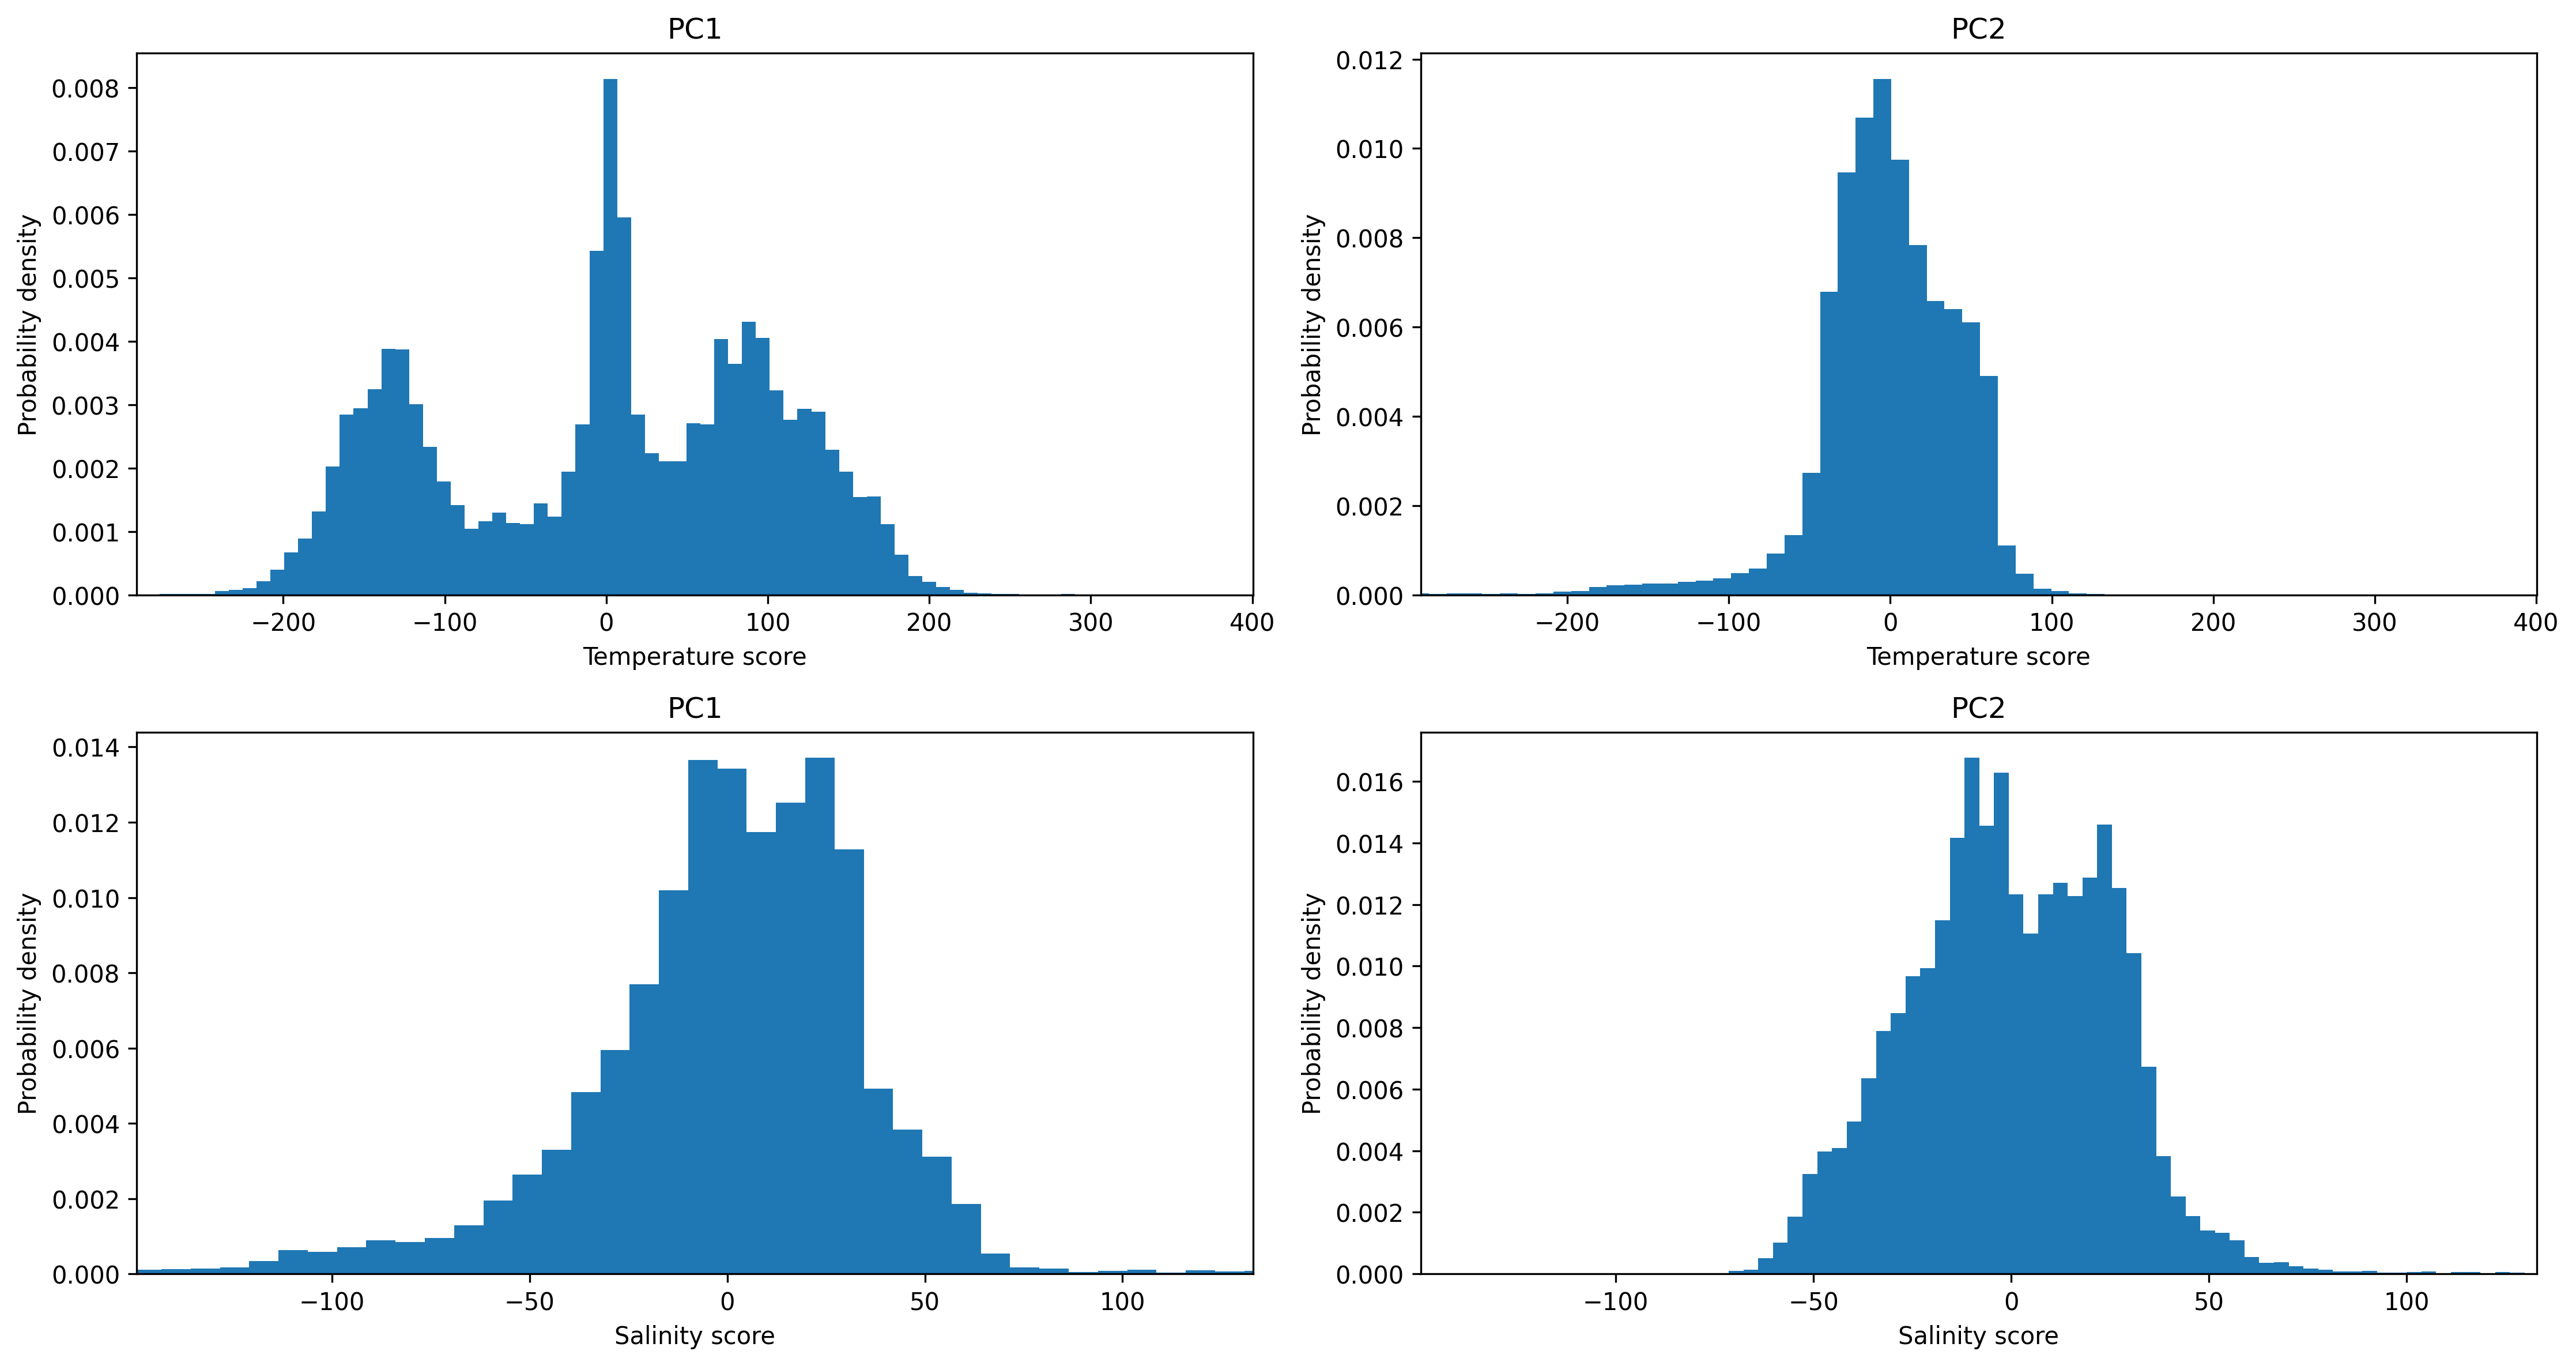

In [33]:
temp_san_score=pca_score(ds_cleaned_750)

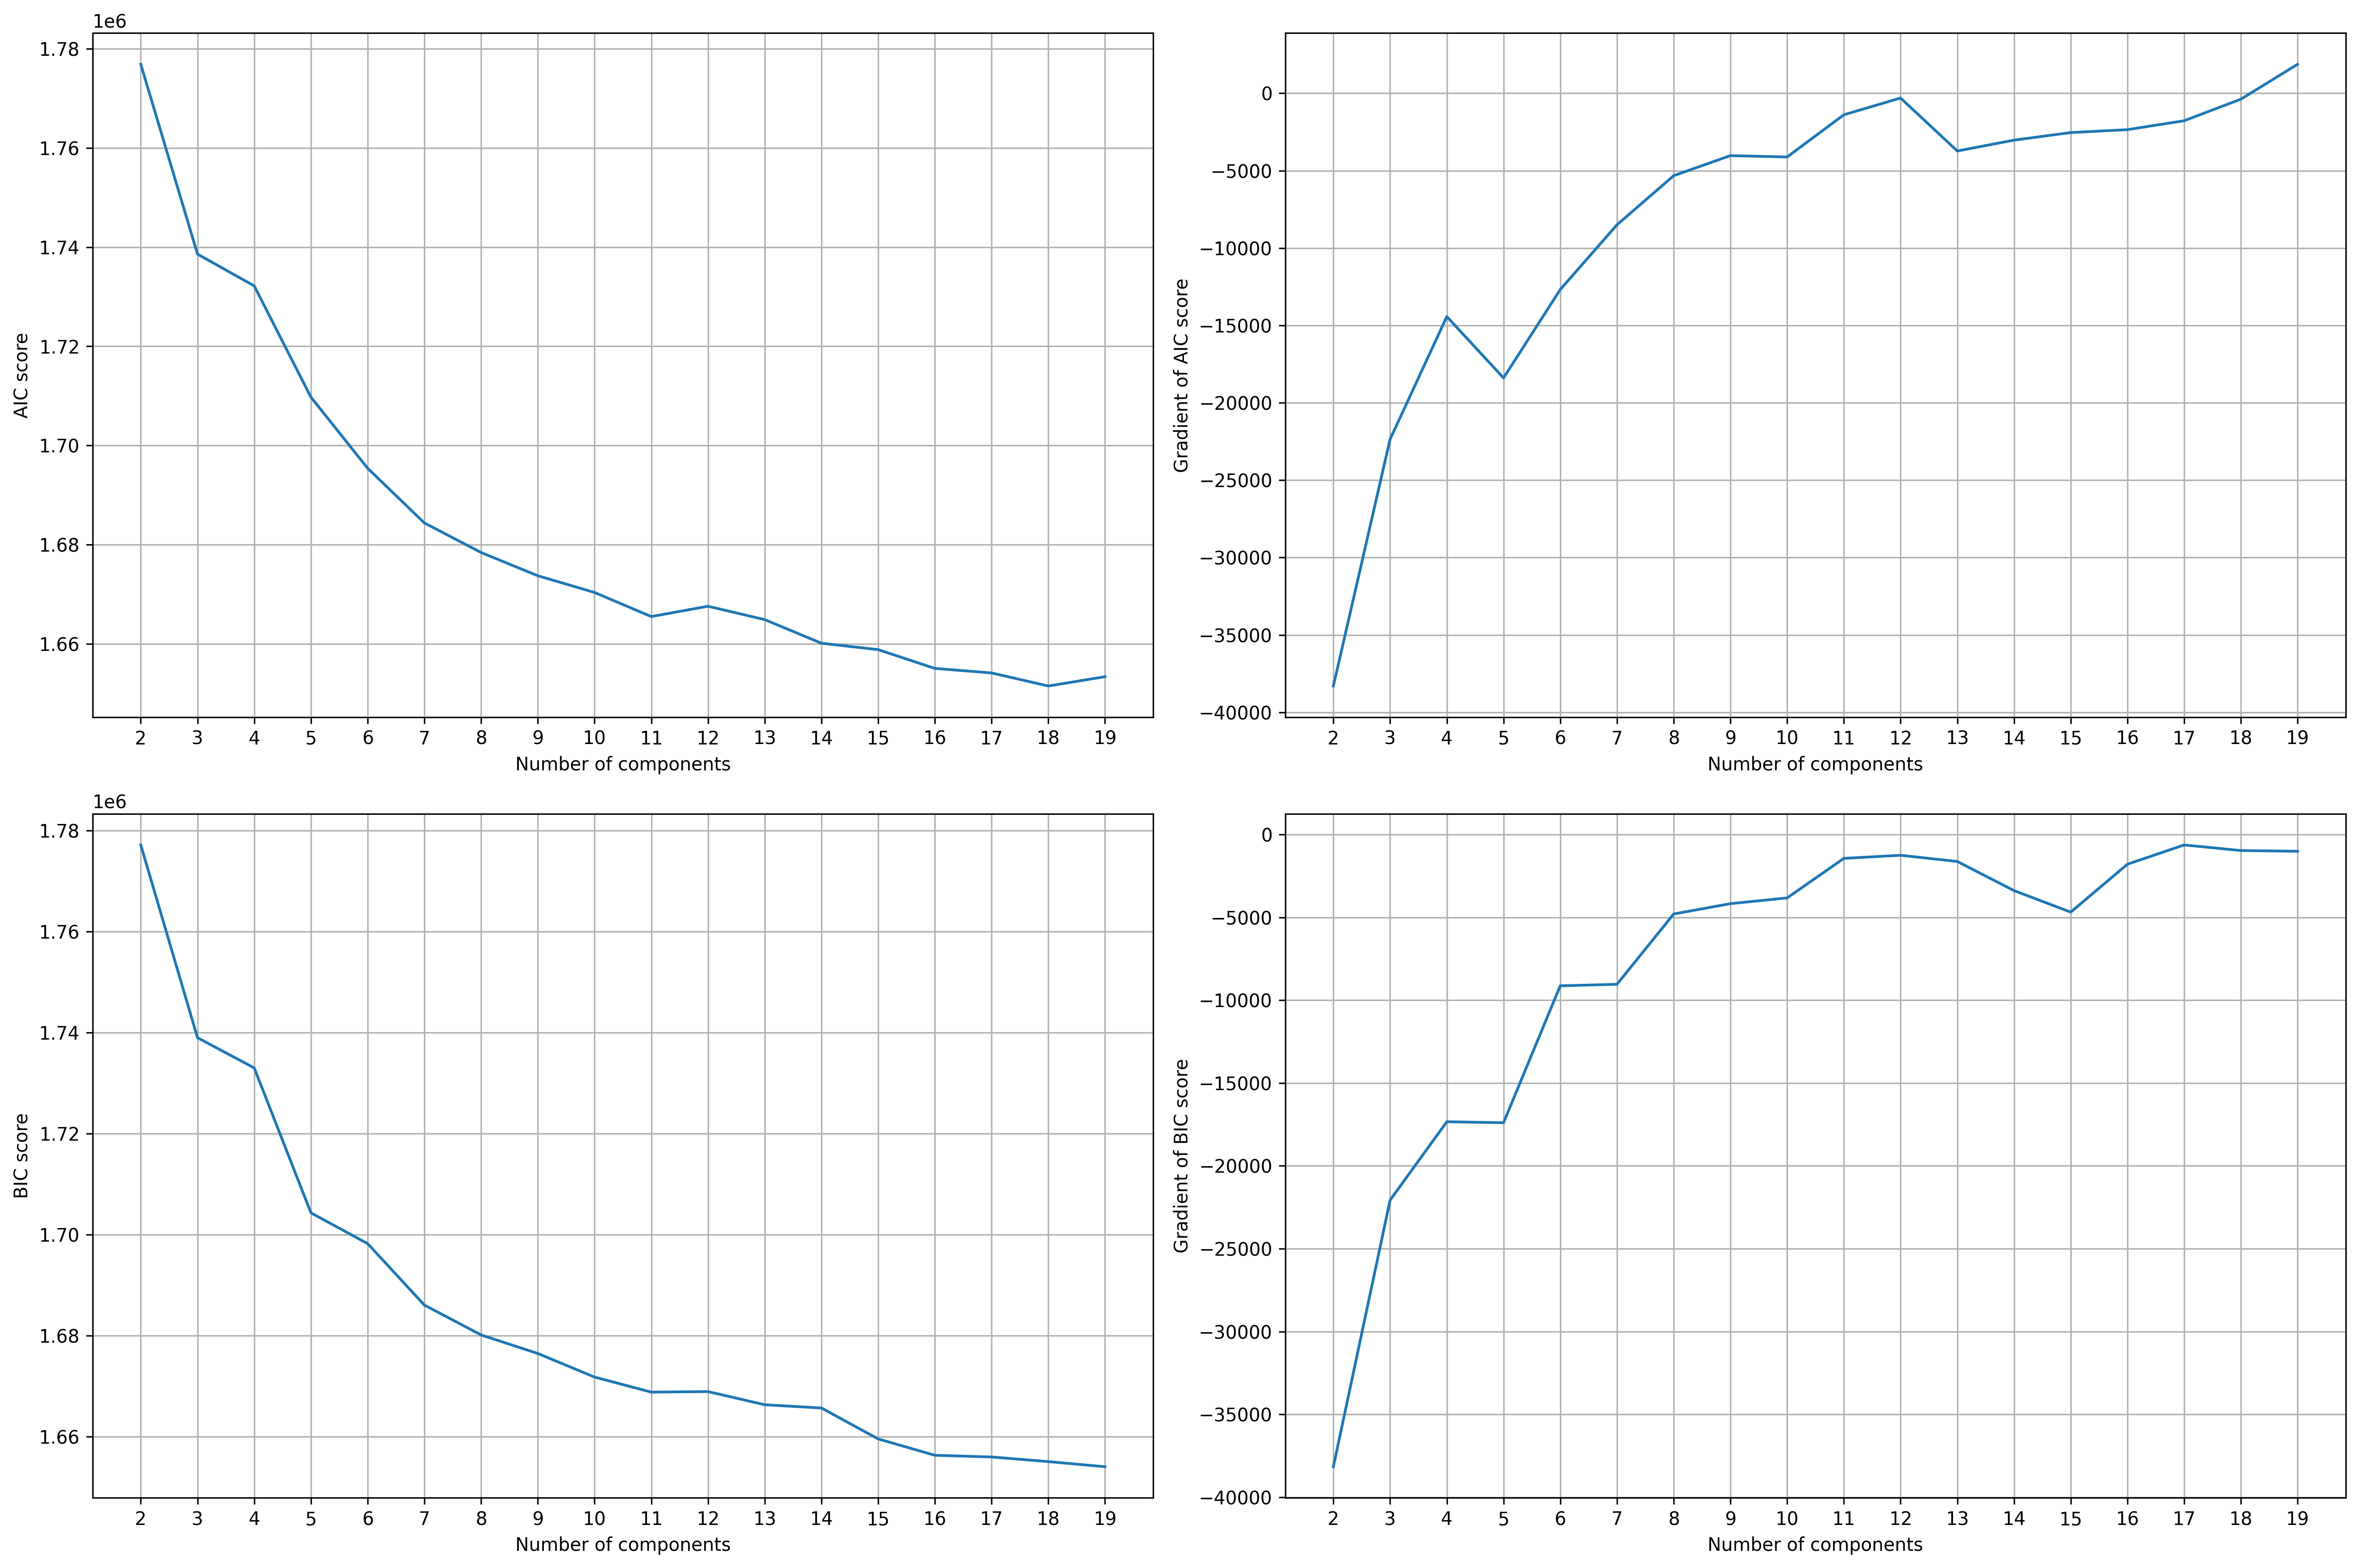

In [40]:
aic_bic_curve(temp_san_score, max_components=20)

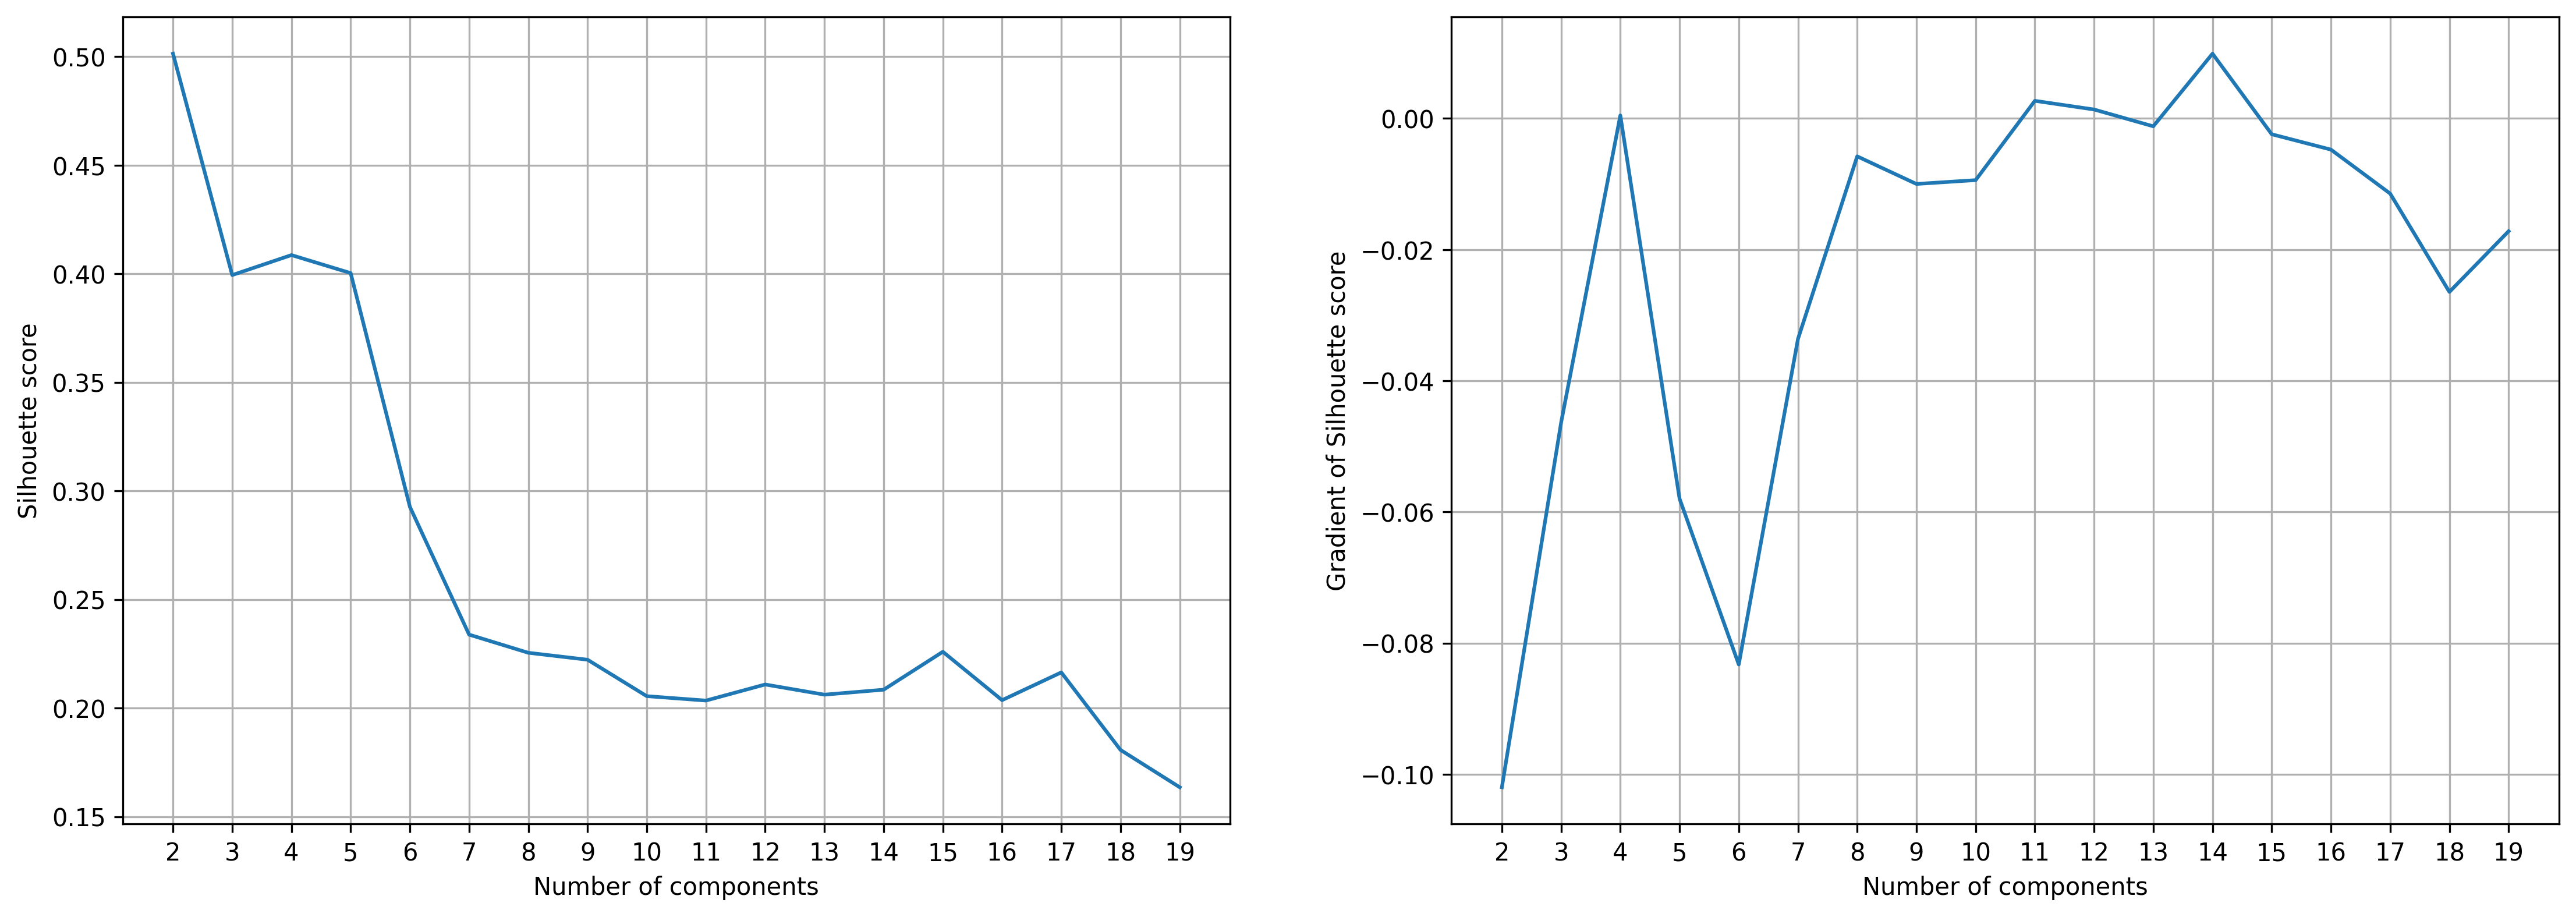

In [49]:
silhouette_score_curve(temp_san_score, max_components=20)

variation explained by PC1 and PC2 for temperature: [0.77213817 0.09876301]
variation explained by PC1 and PC2 for salinity: [0.72888083 0.12812712]


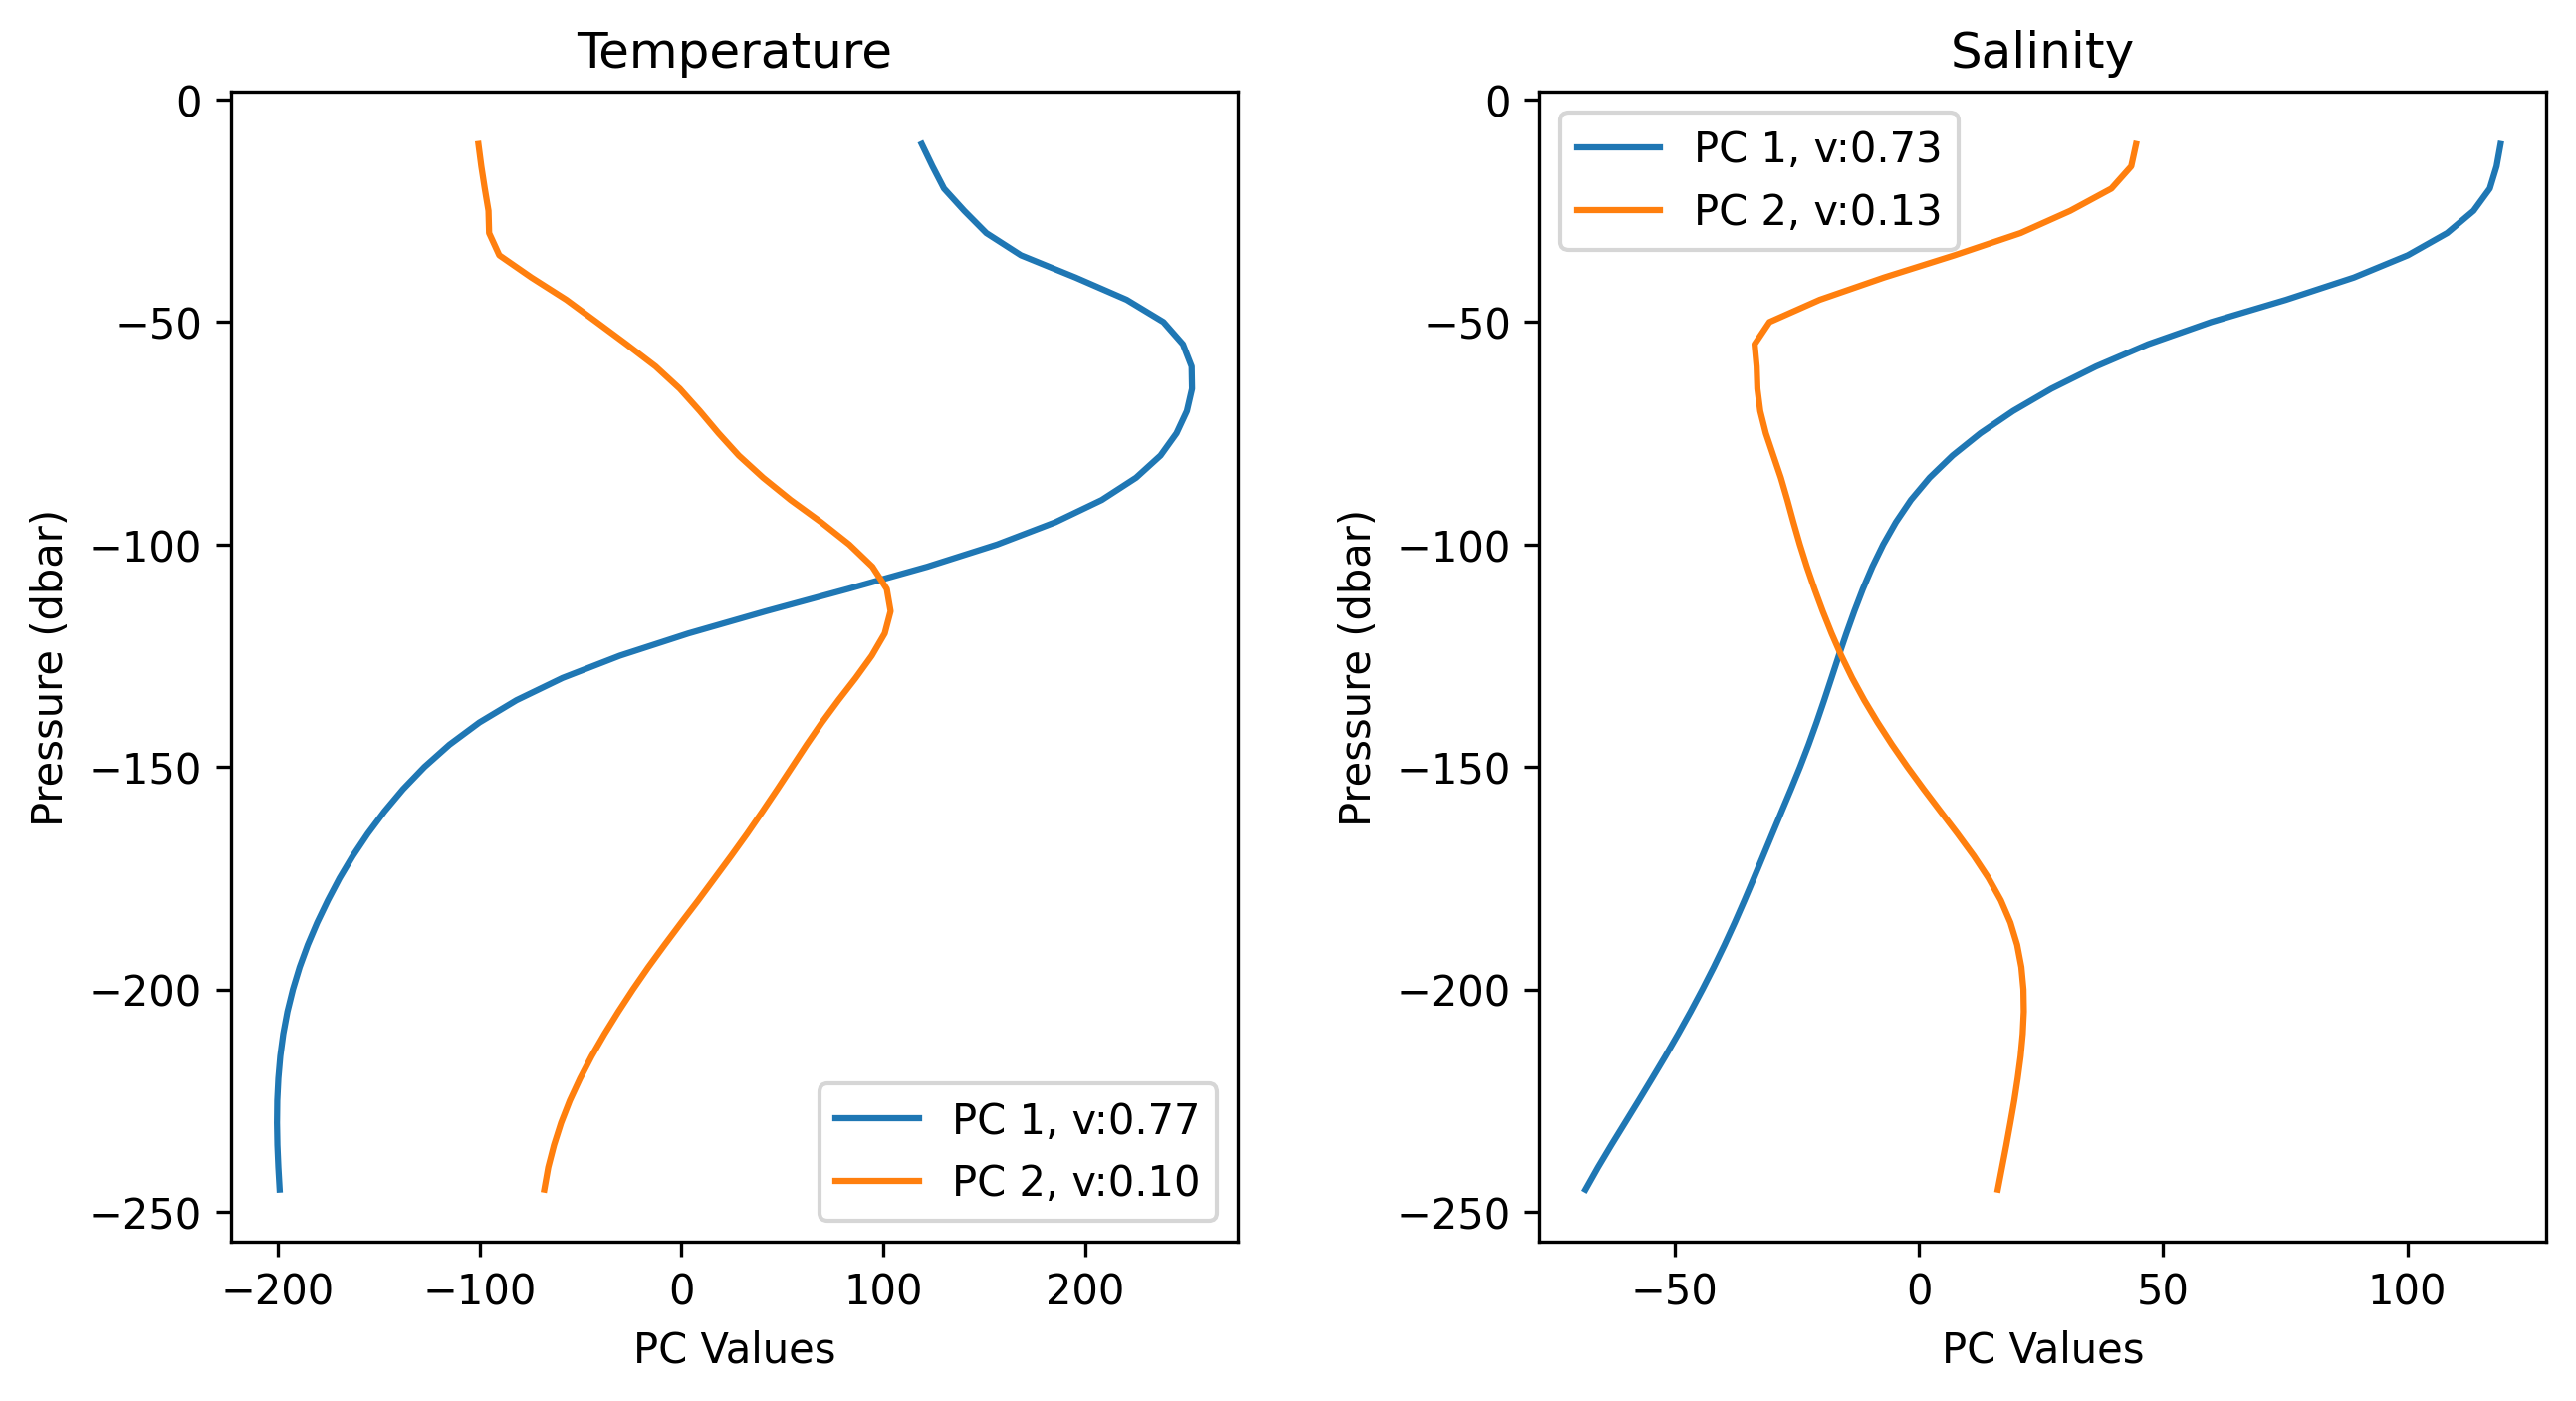

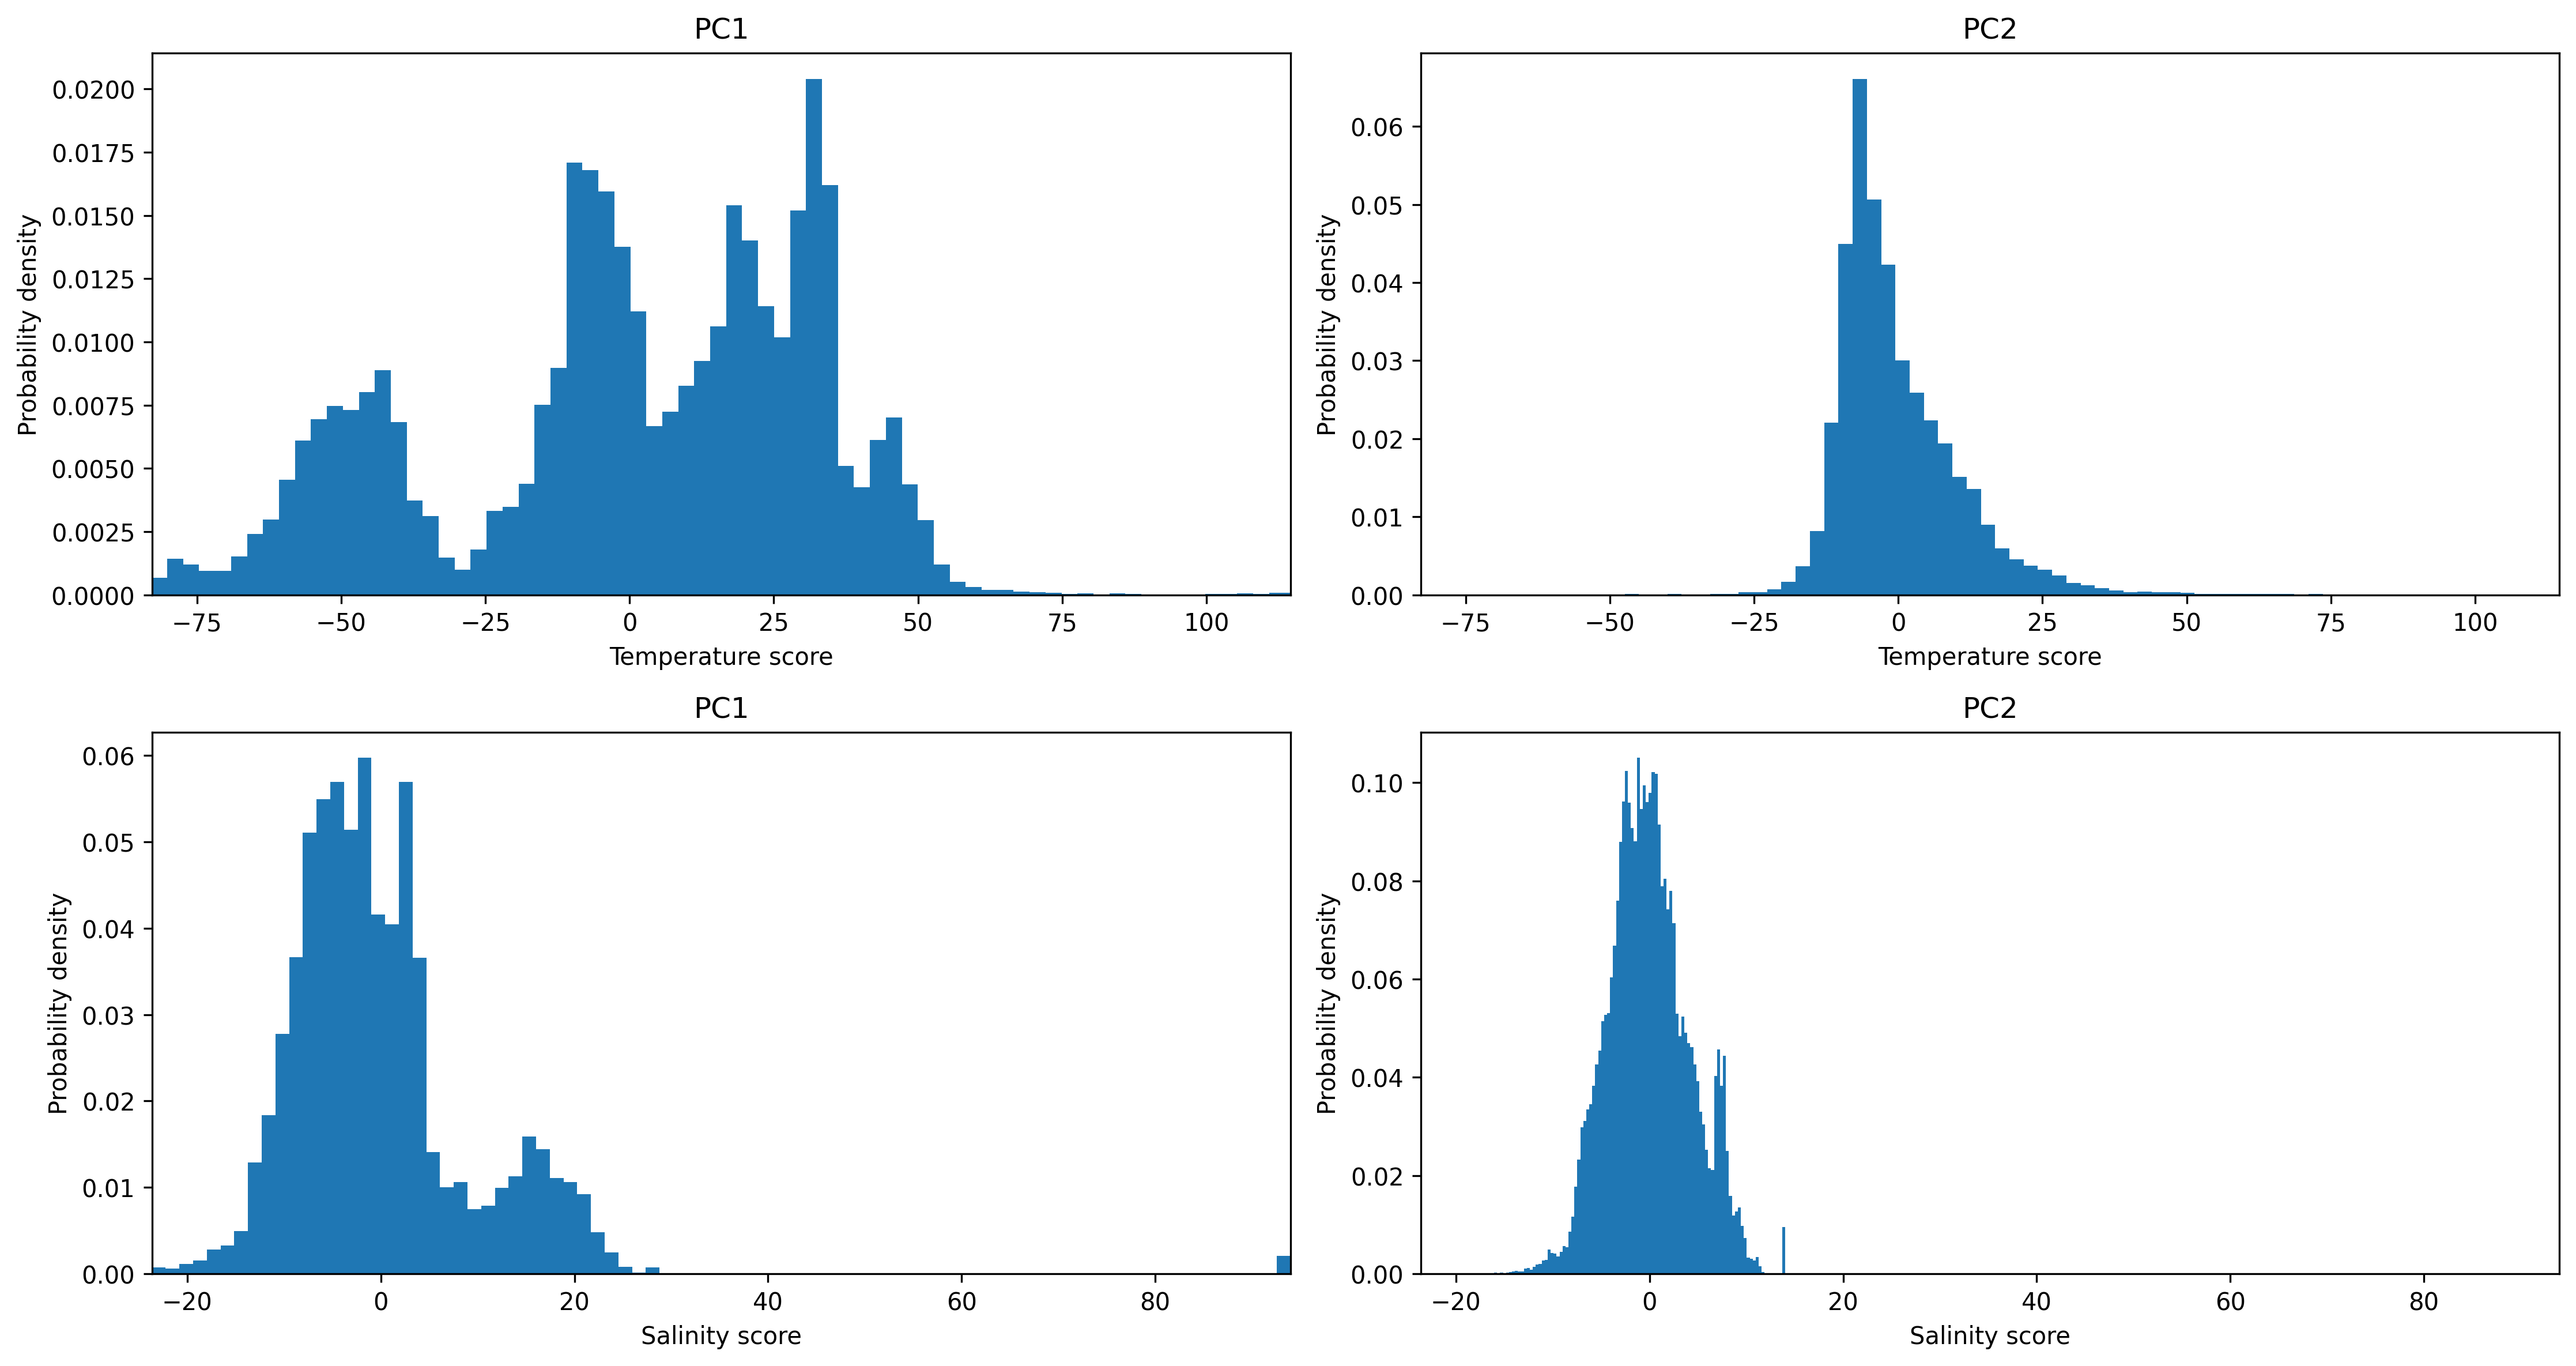

In [52]:
temp_san_score_250=pca_score(ds_cleaned_250)

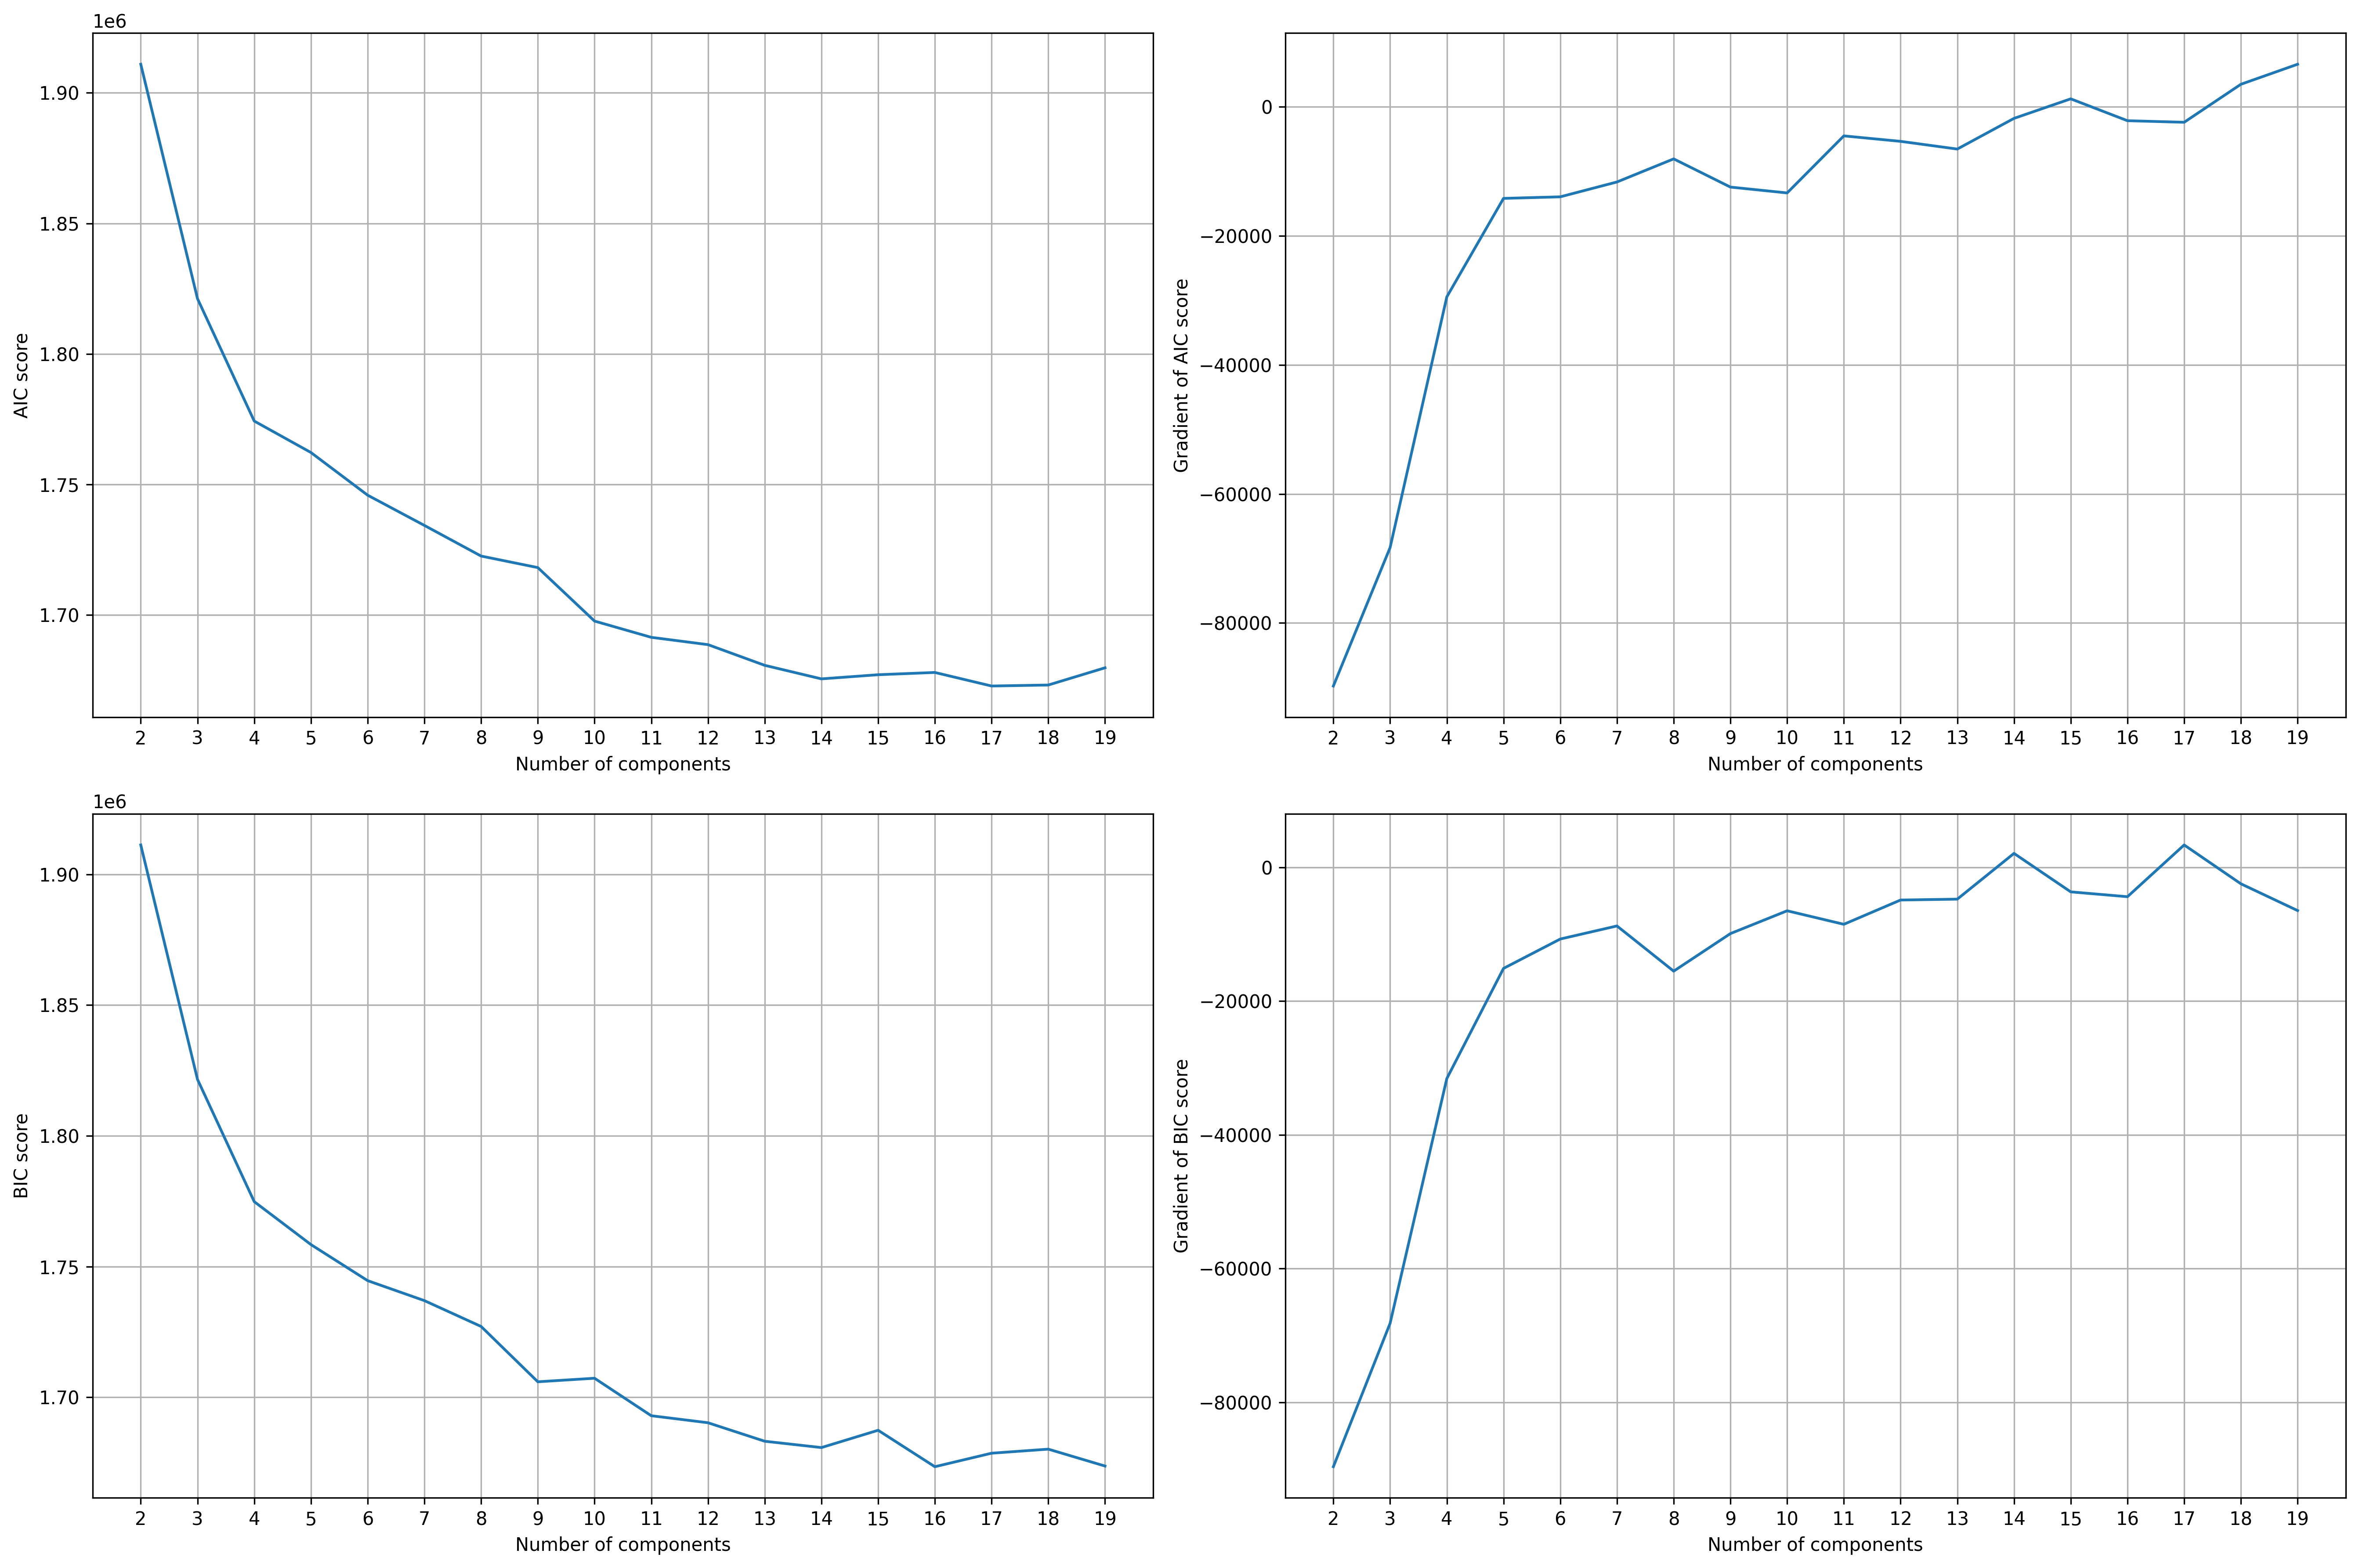

In [53]:
aic_bic_curve(temp_san_score_250, max_components=20)

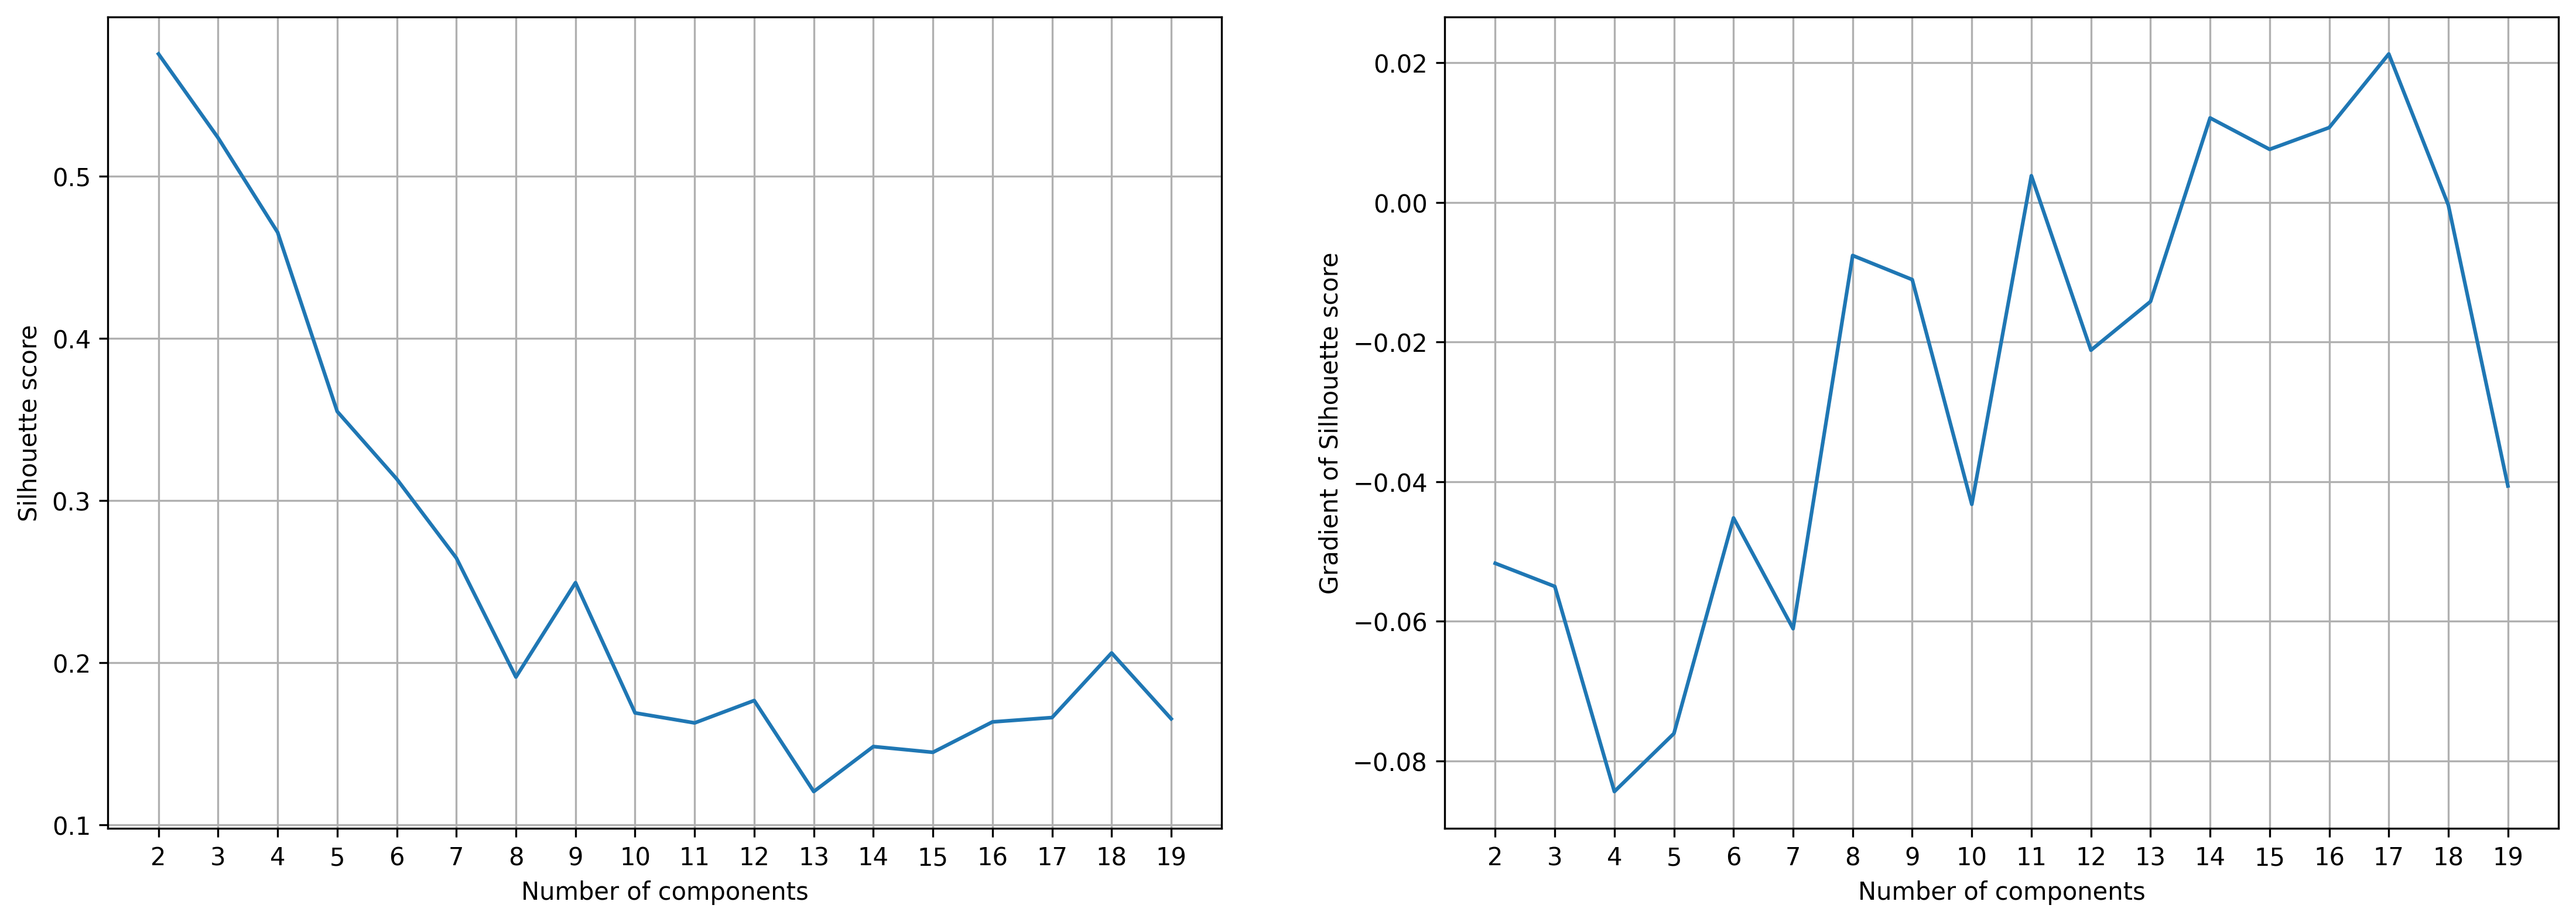

In [54]:
silhouette_score_curve(temp_san_score_250, max_components=20)

In [7]:
# pca
from sklearn.decomposition import PCA
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd


# Normalize the data
scaler = StandardScaler()
temp_scaled = scaler.fit_transform(ds_cleaned['temperature'].values)
san_scaled = scaler.fit_transform(ds_cleaned['salinity'].values)

n_pc=2  # number of principal components
pca_T = PCA(n_components=n_pc)
pca_S=PCA(n_components=n_pc)
columns = [f'pc {i}' for i in range(1, n_pc+1)]

pca_temp = pca_T.fit_transform(temp_scaled.T)
pca_temp_df = pd.DataFrame(data = pca_temp
             , columns = columns)

# pca for salinity
pca_san = pca_S.fit_transform(san_scaled.T)
pca_san_df = pd.DataFrame(data = pca_san
                , columns = columns)

# temp_score=temp_scaled.dot(pca_temp)
# san_score=san_scaled.dot(pca_san)

temp_score=temp_scaled.dot(zscore(pca_temp))
san_score=san_scaled.dot(zscore(pca_san))

# temp_scores = pca_T.transform(temp_scaled)
# temp_loadings = temp_scores.dot(pca_T.components_)

# san_scores = pca_S.transform(san_scaled)


v_exp_temp = pca_T.explained_variance_ratio_
v_exp_san = pca_S.explained_variance_ratio_




In [9]:
pca_temp


array([[ 129.95134126,  167.13267323],
       [ 120.42128625,  167.66844267],
       [ 114.28398408,  164.21644524],
       [ 115.30073132,  157.34019035],
       [ 121.7773932 ,  146.53416723],
       [ 133.07083301,  133.53822634],
       [ 149.05986058,  117.55297751],
       [ 163.89639478,  107.35344497],
       [ 174.76139467,  102.23280342],
       [ 180.25937659,  101.96552408],
       [ 182.23788974,  105.08239016],
       [ 182.04106439,  110.14837566],
       [ 179.919199  ,  115.79168672],
       [ 176.14376933,  120.18505278],
       [ 170.1893982 ,  123.16398815],
       [ 160.13502179,  124.71828974],
       [ 144.8854249 ,  125.21021659],
       [ 122.67044982,  124.16901931],
       [  93.51945118,  121.04473685],
       [  56.71204804,  114.80532681],
       [  15.37951041,  105.24389132],
       [ -24.97847873,   93.13552685],
       [ -59.90968919,   80.48381805],
       [ -87.3088613 ,   68.82977094],
       [-107.25682216,   58.63884922],
       [-121.81737644,   

In [10]:
temp_score

array([[ 85.22104396, -27.73526442],
       [ 79.90884239, -36.43476123],
       [ 67.62391195, -38.94961239],
       ...,
       [  8.37523584,  55.50090927],
       [-10.52492173,  62.89912898],
       [  3.89146776,  60.13010665]])

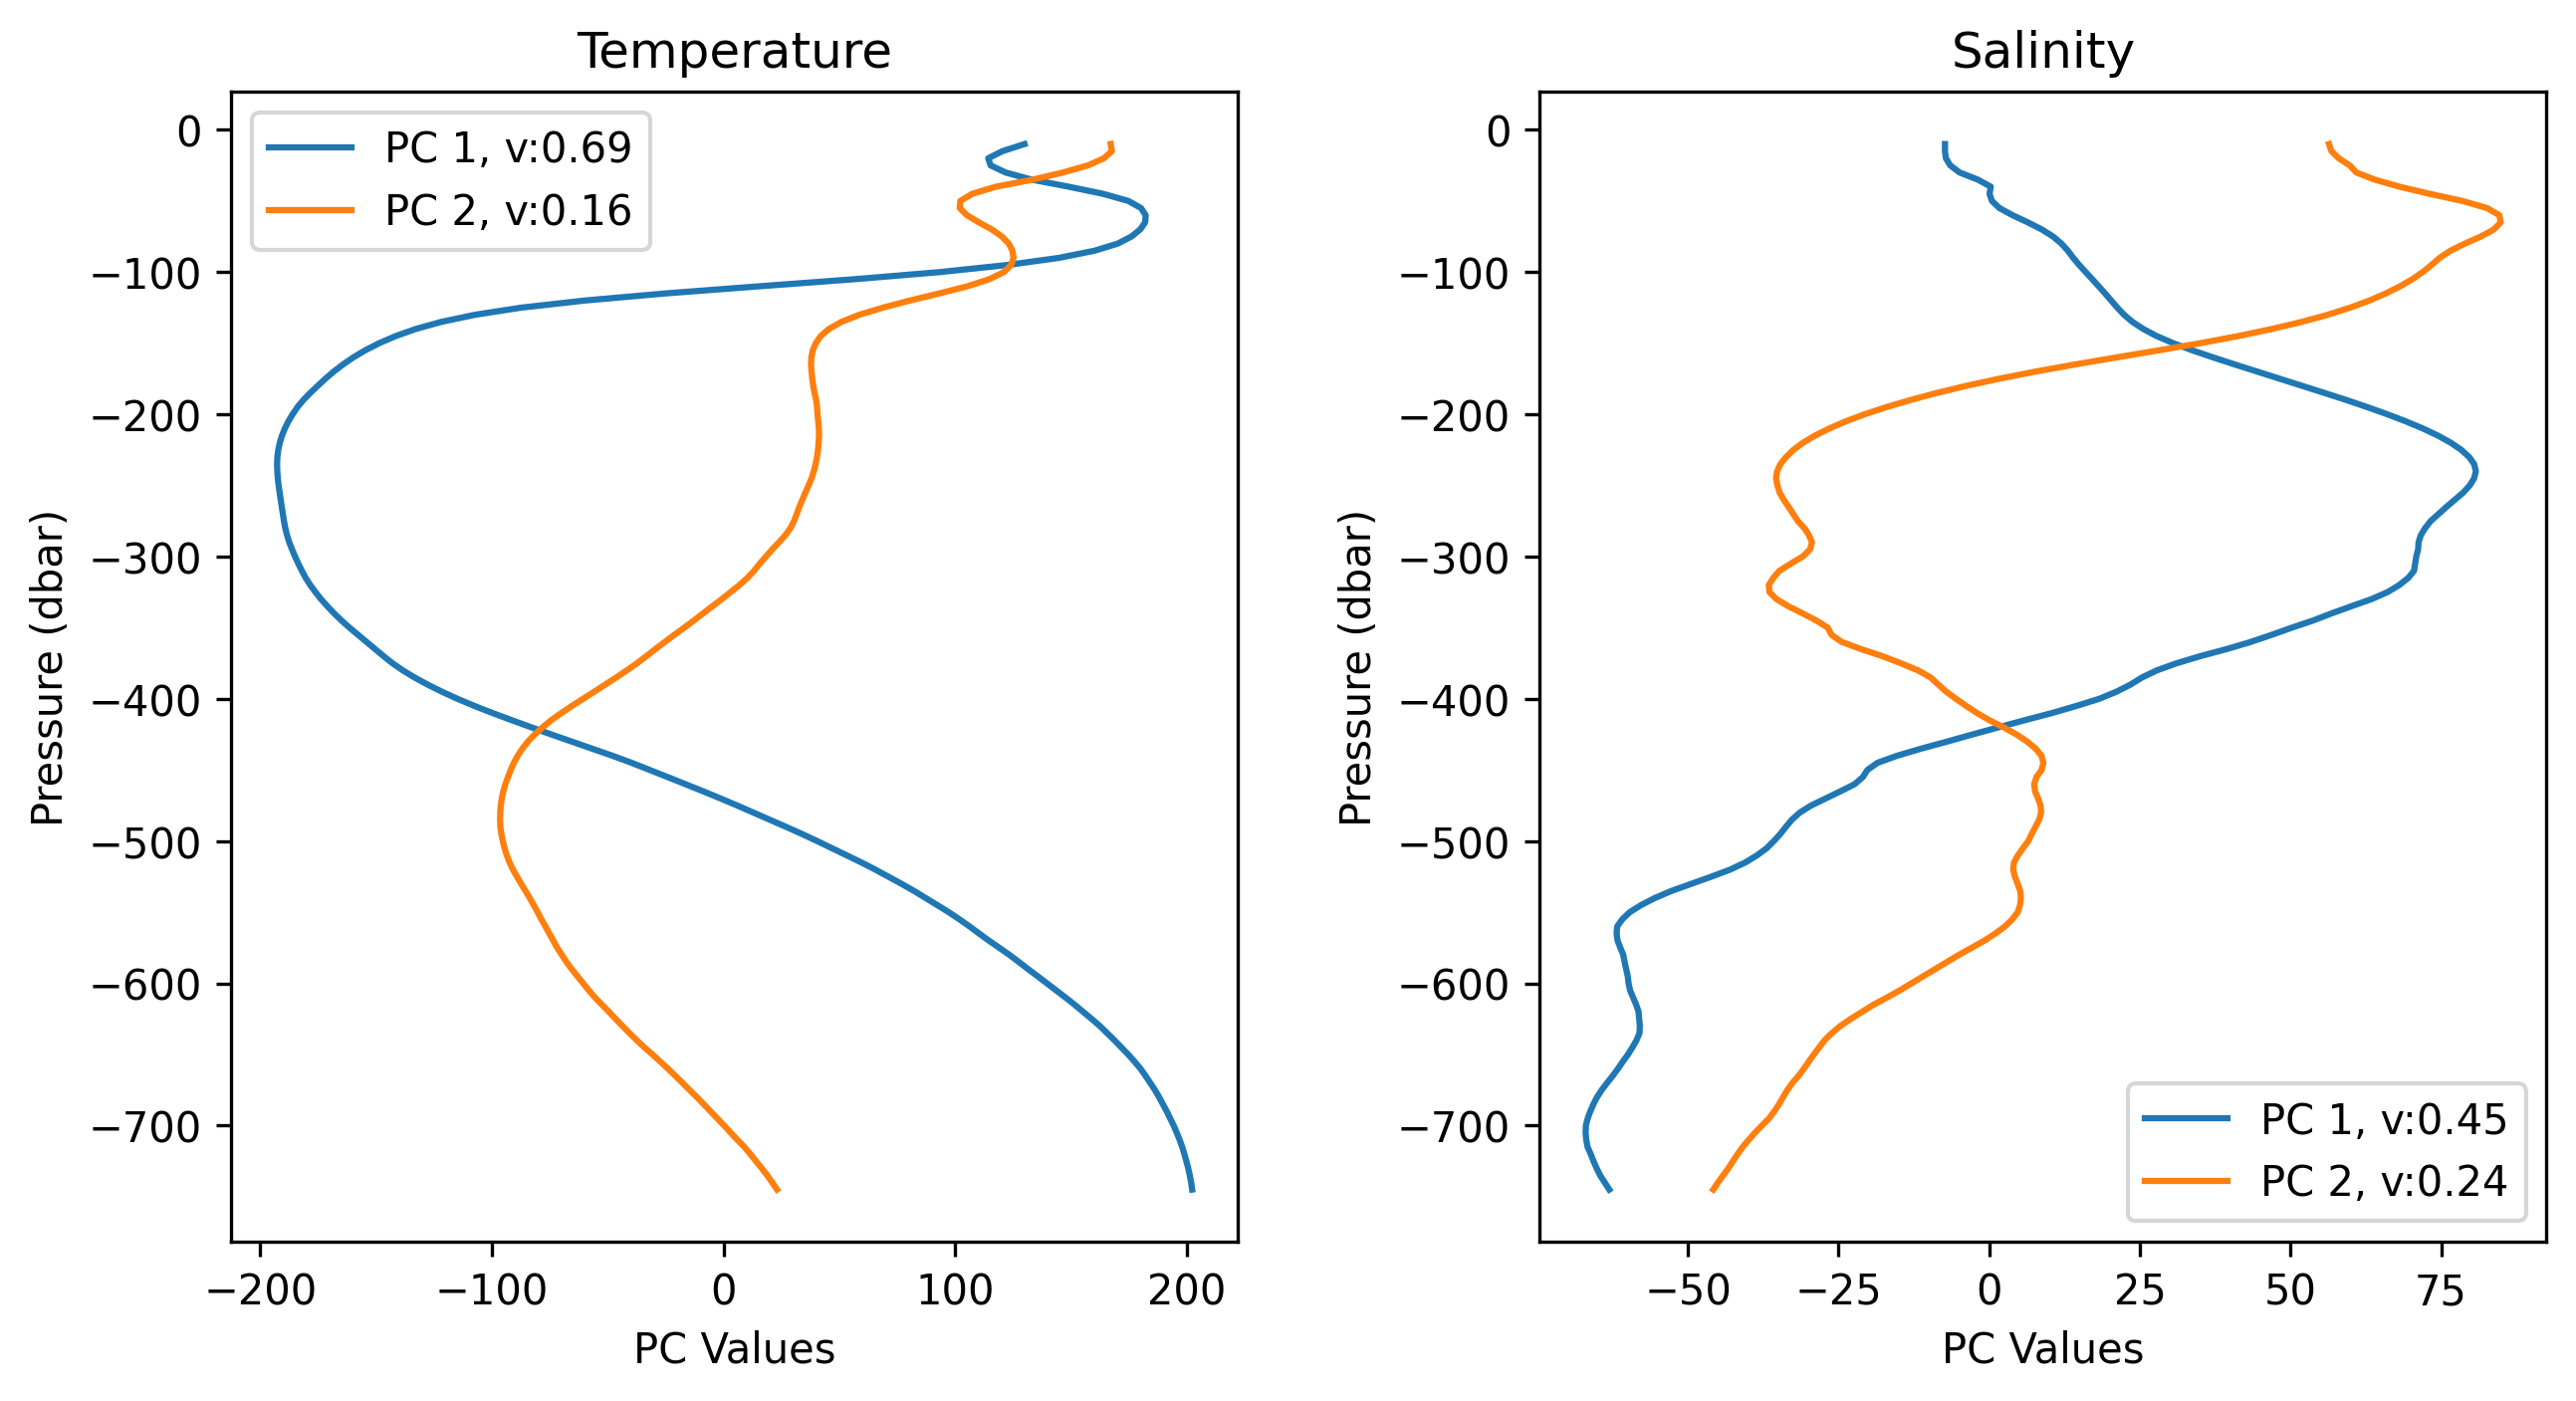

In [11]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5),dpi=300)

# Loop through all the PCs and plot them for temperature and salinity
for i in range(n_pc):
    # Plot the i-th PC for temperature in the left subplot
    axes[0].plot(pca_temp_df[f'pc {i+1}'], ds_cleaned['pressure'], label=f'PC {i+1}, v:{v_exp_temp[i]:.2f}')
    axes[0].set_title('Temperature')
    axes[0].set_xlabel('PC Values')
    axes[0].set_ylabel('Pressure (dbar)')
    # axes[0].invert_yaxis()
    axes[0].legend()
    
    # Plot the i-th PC for salinity in the right subplot
    axes[1].plot(pca_san_df[f'pc {i+1}'], ds_cleaned['pressure'], label=f'PC {i+1}, v:{v_exp_san[i]:.2f}')
    axes[1].set_title('Salinity')
    axes[1].set_xlabel('PC Values')
    axes[1].set_ylabel('Pressure (dbar)')
    # axes[1].invert_yaxis()
    axes[1].legend()
    

# Adjust the spacing between the subplots
fig.subplots_adjust(wspace=0.3)

# Show the figure
plt.show()



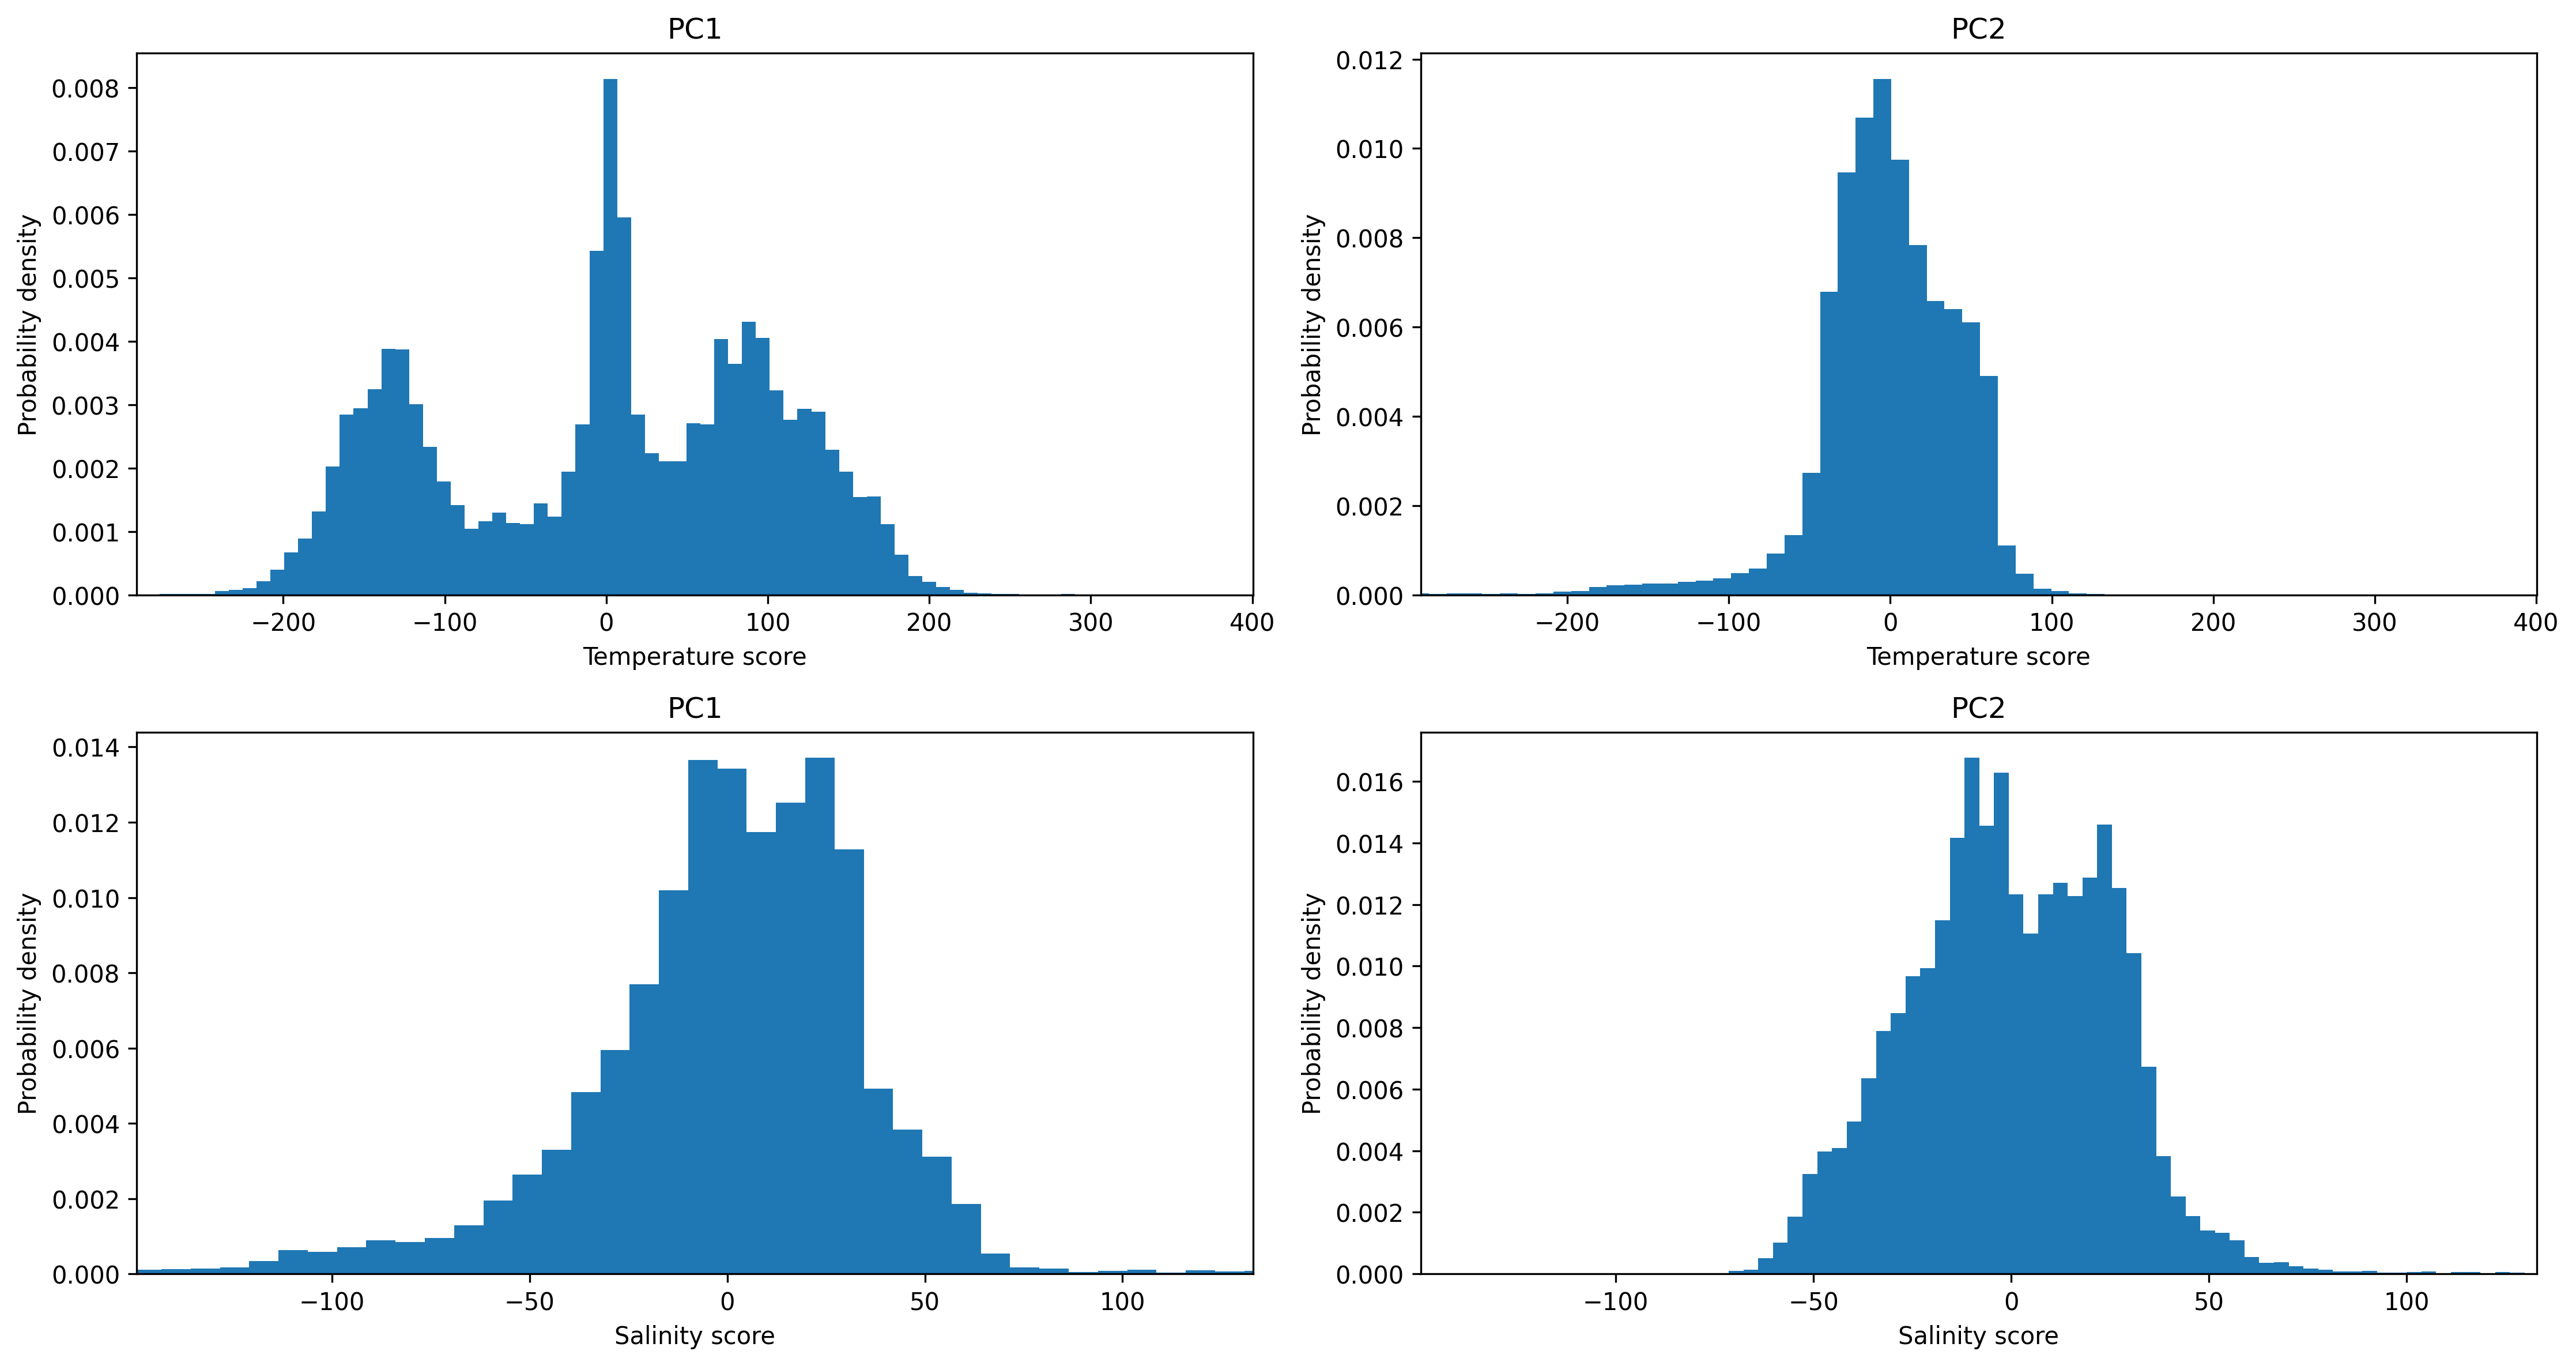

In [12]:

# plot the scores
import matplotlib.pyplot as plt

n_cols = temp_score.shape[1]  # number of principal components
fig, axs = plt.subplots(nrows=2, ncols=n_cols, figsize=(15, 8),dpi=300)

for i in range(n_cols):
    axs[0,i].hist(temp_score[:, i], bins=100,density=True)
    axs[0,i].set_xlim(np.quantile(temp_score,0.001), np.quantile(temp_score,0.999))
    axs[0,i].set_title(f'PC{i+1}')
    axs[0,i].set_xlabel('Temperature score')
    axs[0,i].set_ylabel('Probability density')
    #axs[0,i].set_yticklabels([str(int(ytick/len(temp_score))) for ytick in axs[0,i].get_yticks()])  # set ytick labels divided by 2

    axs[1,i].hist(san_score[:, i], bins=100,density=True)
    axs[1,i].set_xlim(np.quantile(san_score,0.001), np.quantile(san_score,0.999))
    axs[1,i].set_title(f'PC{i+1}')
    axs[1,i].set_xlabel('Salinity score')
    axs[1,i].set_ylabel('Probability density')
    # axs[1,i].set_yticklabels([str(int(ytick/len(temp_score))) for ytick in axs[1,i].get_yticks()])  # set ytick labels divided by 2

plt.tight_layout()
plt.show()



In [16]:
# put temperature and salinity scores together
temp_san_score=np.concatenate((temp_score,san_score),axis=1)
temp_san_score.shape

(44692, 4)

In [36]:
# calculate the bic score for the GMM model
from sklearn.mixture import GaussianMixture
gmm_model = GaussianMixture(n_components=6, covariance_type='full')
gmm_model.fit(temp_san_score)
# gmm_model.bic(temp_san_score)
gmm_model.aic(temp_san_score)


1690931.4456806974

In [41]:
# calculate the silhouette_score
from sklearn.metrics import silhouette_score
ss=silhouette_score(temp_san_score, gmm_model.predict(temp_san_score))
ss

0.2925861847462756

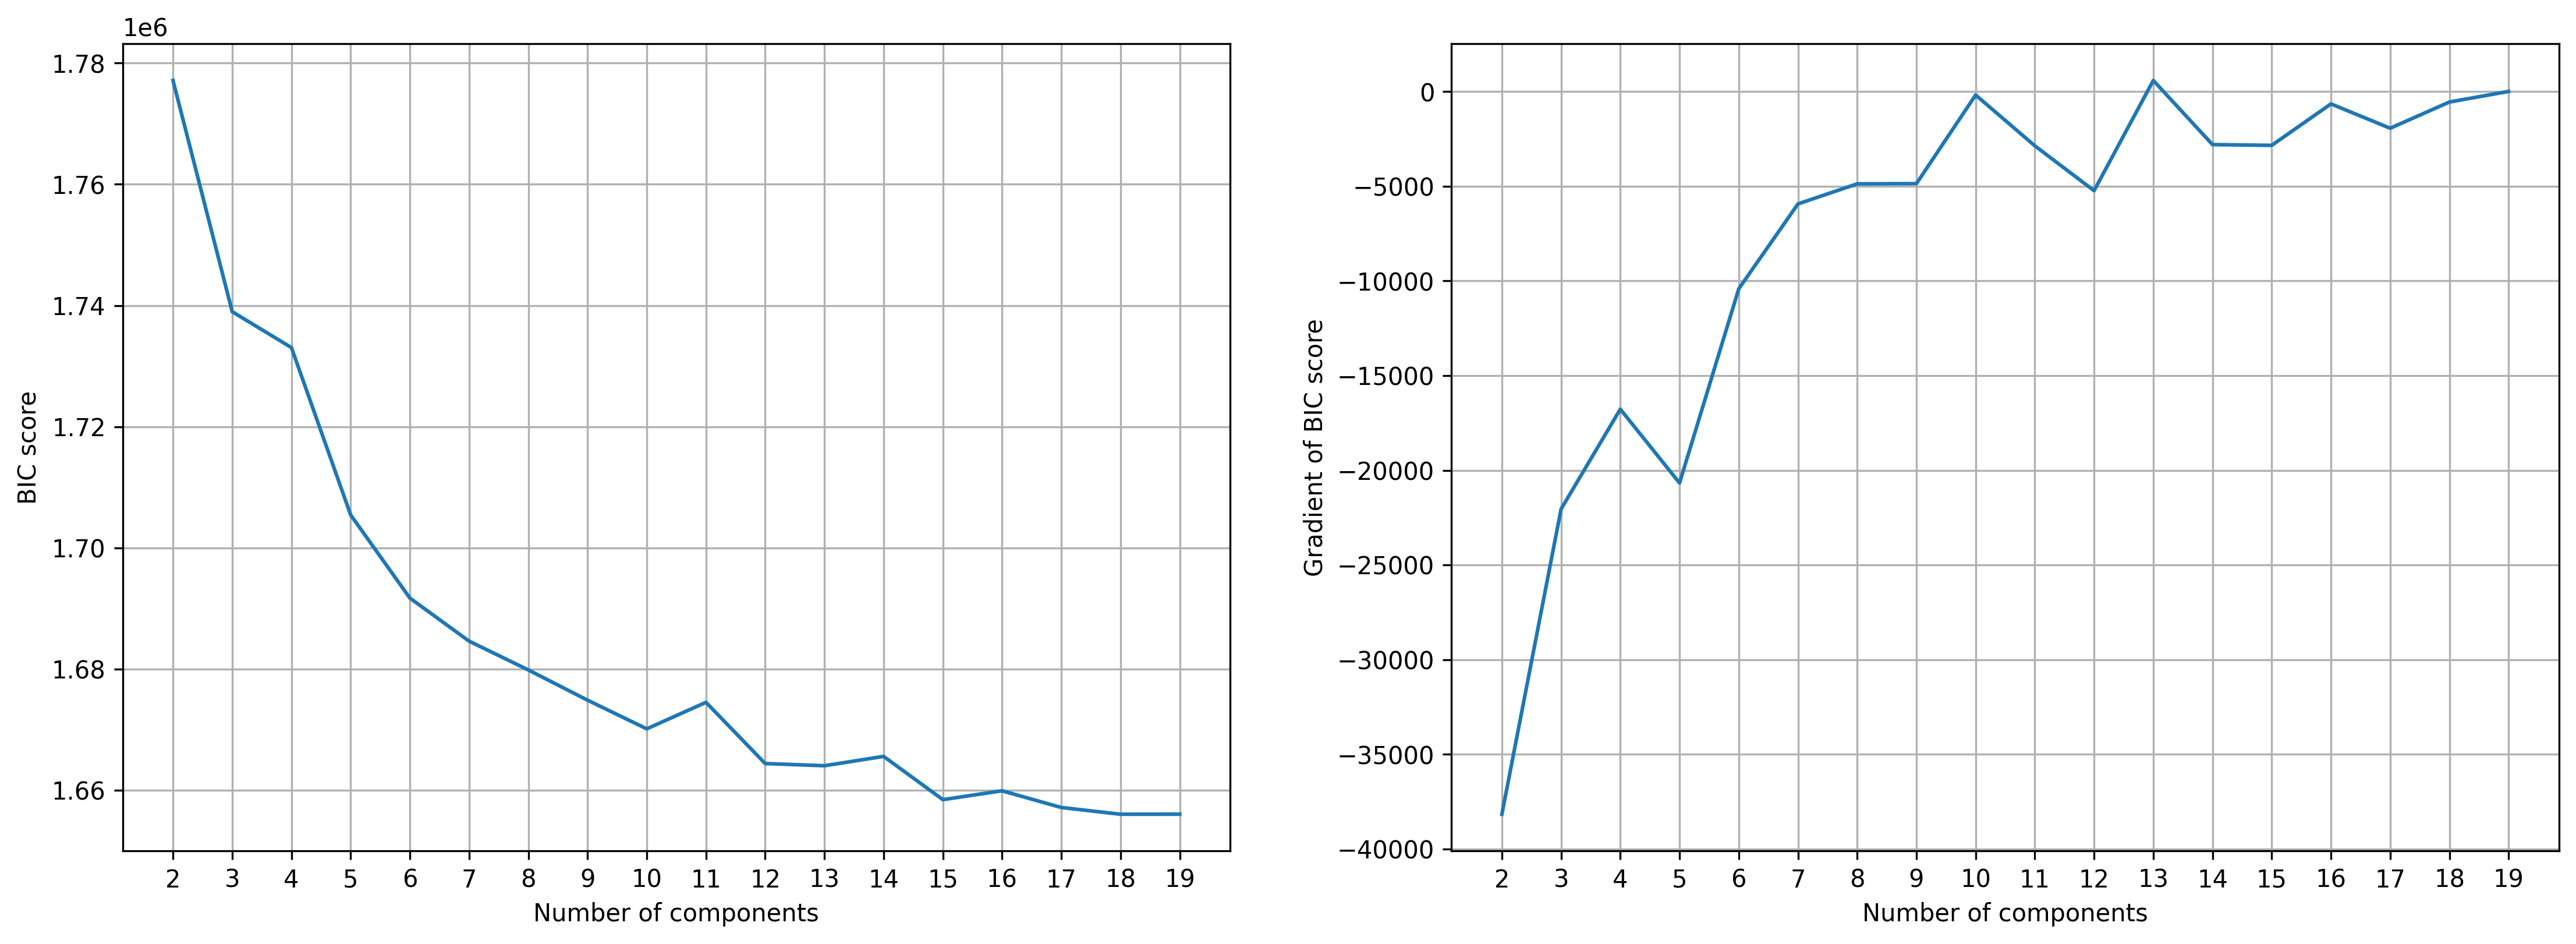

In [20]:
# set n_components to 2 to 10 and calculate the bic score for each model and plot the results
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

max_components = 20
bic = []
for i in range(2, max_components):
    gmm_model = GaussianMixture(n_components=i, covariance_type='full')
    gmm_model.fit(temp_san_score)
    bic.append(gmm_model.bic(temp_san_score))

# calculate the gradient of bic
bic_grad = np.gradient(bic)
# plot bic and bic_grad vs n_components side by side
plt.figure(figsize=(18, 6),dpi=300)
plt.subplot(1, 2, 1)
plt.plot(range(2, max_components), bic)
# set xticks to be integers
plt.xticks(range(2, max_components))
plt.xlabel('Number of components')
plt.ylabel('BIC score')
plt.grid()
plt.subplot(1, 2, 2)
plt.plot(range(2, max_components), bic_grad)
# set xticks to be integers
plt.xticks(range(2, max_components))
plt.xlabel('Number of components')
plt.ylabel('Gradient of BIC score')
# add grid
plt.grid()
plt.show()